# INIT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librerias

In [2]:
!pip install featuretools # install the missing module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 18.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules import preprocessing_module as pm
from modules import kmeans_module as km_m
from modules.get_data import get_data
from modules import feature_creation_module as fcm

## Importacion datos

In [4]:
# Diccionario colecciones
db_collections = [
    'calendar',
    'items',
    'prices',
    'tiendas',
    'departments',
    'sales_main',
    'weekly_sales',
    'year_sales',
    'day_sales'
    ]

### CSVs

In [5]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
# df_ws = get_data('exp_weekly_sales.csv')
df_ws = get_data('daily_sales_with_events.csv') # Vamos a probar con diarias -> filtramos por años para que no pete la creacion de caracteristicas

/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering/modules/get_data.py:23: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [6]:
display(df_cal.head())
display(df_items.head())
display(df_shops.head())
display(df_ws.head())

fecha           event
0  2011-02-06       SuperBowl
1  2011-08-01  Ramadan starts
2  2011-11-24    Thanksgiving
3  2012-01-01         NewYear
4  2012-02-05       SuperBowl

item    category    department
0  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1
1  ACCESORIES_1_002  ACCESORIES  ACCESORIES_1
2  ACCESORIES_1_003  ACCESORIES  ACCESORIES_1
3  ACCESORIES_1_004  ACCESORIES  ACCESORIES_1
4  ACCESORIES_1_005  ACCESORIES  ACCESORIES_1

store_code    region              store
0      NYC_1  New York  Greenwich_Village
1      NYC_2  New York             Harlem
2      NYC_3  New York            Tribeca
3      NYC_4  New York           Brooklyn
4      BOS_1    Boston          South_End

item store_code        date  units  year  week  sell_price  \
0  ACCESORIES_1_008      NYC_1  2011-01-29     12  2011     4      0.6118   
1  ACCESORIES_1_009      NYC_1  2011-01-29      2  2011     4      2.0748   
2  ACCESORIES_1_015      NYC_1  2011-01-29      4  2011     4      0.9310   
3  ACCESORIES_1_016      NYC_1  2011-01-29      5  2011     4      0.9310   
4  ACCESORIES_1_022      NYC_1  2011-01-29      2  2011     4      9.1238   

   raw_earn  month  day_name  weekday_number event  
0    7.3416      1  Saturday               5   NaN  
1    4.1496      1  Saturday               5   NaN  
2    3.7240      1  Saturday               5   NaN  
3    4.6550      1  Saturday               5   NaN  
4   18.2476      1  Saturday               5   NaN

In [7]:
# Seleccionar solo años 2014 a 2016 de df_ws
df_ws = df_ws[(df_ws['year'] >= 2014) & (df_ws['year'] <= 2016)]

# Cambiamos NaN de event por None
df_ws['event'] = df_ws['event'].fillna('None')

In [8]:
df_ws.shape

(9693001, 12)

# **CREACION CARACTERISTICAS**
___
___  
  
Creamos las caracteristicas generales y luego filtraremos para cada supuesto.

In [9]:
# V2
fc_config = {
    'target_df': 'items',  # Nombre del DataFrame objetivo
    'agg_primitives': [
        'min',               # Mínimo
        'max',               # Máximo
        'mean',              # Promedio
        'std',               # Desviación estándar
        'sum',               # Suma
        'count'              # Totales
    ],
    'trans_primitives': [
        # 'divide_numeric',    # División entre características numéricas -> GENERA MUCHAS!!!
        'percentile'       # Porcentaje de ventas respecto a la tienda de mayor rendimiento
    ],
    'max_depth': 2         # Profundidad máxima de la generación de características
}


feature_matrix, feature_defs = fcm.create_features(df_items, df_shops, df_ws, fc_config)

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

In [10]:
print(f'FeatMatrix shape : {feature_matrix.shape}')

print(f'Feat Defs length: {len(feature_defs)}')

FeatMatrix shape : (3049, 109)
Feat Defs length: 109


### Feat Descriptions

In [11]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: category>: The "category".',
 '<Feature: department>: The "department".',
 '<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.month)>: The maximum of the "month" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.raw_earn)>: The maximum of the "raw_earn" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.sell_price)>: The maximum of the "sell_price" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.units)>: The maximum of the "units" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.week)>: The maximum of the "week" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.weekday_number)>: The maximum of the "weekday_number" of all instances of "sales" for each "item" in "items".',
 '<Feature: MAX(sales.year)>: The maximum of the "year" of all instances of "sales" for ea

__Filtrado caracteristicas usando liberira FeatureTools__
**Feature encode** (codifica categorical)

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-encoding

**Feature selection**

> https://featuretools.alteryx.com/en/stable/api_reference.html#feature-selection  
  
- *remove_low_information_features(feature_matrix)*  
Select features that have at least 2 unique values and that are not all null

- *remove_highly_correlated_features(feature_matrix)*  
Removes columns in feature matrix that are highly correlated with another column.

- *remove_highly_null_features(feature_matrix)*  
Removes columns from a feature matrix that have higher than a set threshold of null values.

- *remove_single_value_features(feature_matrix)*  
Removes columns in feature matrix where all the values are the same.

# **PRODUCTOS: PERFORMANCE**
___
___

### Seleccion Features

In [12]:
# V3
substrings = ['units', 'raw_earn']
# substrings = ['raw_earn'] # Nos quedamos solo con las que afectan a los ingresos

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 30
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 30
Shape after filtering: 24
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


MAX(sales.raw_earn)  MAX(sales.units)  MEAN(sales.raw_earn)  \
item                                                                            
ACCESORIES_1_001              65.9148               6.0             15.315095   
ACCESORIES_1_002              31.6806               6.0              6.694430   
ACCESORIES_1_003              23.7006               6.0              4.806321   
ACCESORIES_1_004             123.4240              20.0             21.065210   
ACCESORIES_1_005              34.4736               9.0              6.509380   

                  MEAN(sales.units)  MIN(sales.raw_earn)  STD(sales.raw_earn)  \
item                                                                            
ACCESORIES_1_001           1.393241               6.6500             7.921939   
ACCESORIES_1_002           1.268571               2.6600             3.270445   
ACCESORIES_1_003           1.220238               1.2901             2.159986   
ACCESORIES_1_004           3.413471               6.1712            17.589802   
ACCESORIES_1_005           1.704463               2.6600             3.881594   

                  STD(sales.units)  SUM(sales.raw_earn)  \
item                                                      
ACCESORIES_1_001          0.720229           38517.4650   
ACCESORIES_1_002          0.618826           11715.2518   
ACCESORIES_1_003          0.548854            5652.2340   
ACCESORIES_1_004          2.850305          110402.7680   
ACCESORIES_1_005          1.010506           25087.1516   

                  MAX(sales.PERCENTILE(raw_earn))  \
item                                                
ACCESORIES_1_001                         0.984823   
ACCESORIES_1_002                         0.933045   
ACCESORIES_1_003                         0.889363   
ACCESORIES_1_004                         0.996682   
ACCESORIES_1_005                         0.942635   

                  MAX(sales.PERCENTILE(units))  ...  \
item                                            ...   
ACCESORIES_1_001                      0.883327  ...   
ACCESORIES_1_002                      0.883327  ...   
ACCESORIES_1_003                      0.883327  ...   
ACCESORIES_1_004                      0.985091  ...   
ACCESORIES_1_005                      0.937677  ...   

                  STD(sales.PERCENTILE(units))  \
item                                             
ACCESORIES_1_001                      0.175472   
ACCESORIES_1_002                      0.153295   
ACCESORIES_1_003                      0.142443   
ACCESORIES_1_004                      0.269945   
ACCESORIES_1_005                      0.212386   

                  SUM(sales.PERCENTILE(raw_earn))  \
item                                                
ACCESORIES_1_001                      1857.415016   
ACCESORIES_1_002                       749.350268   
ACCESORIES_1_003                       360.562173   
ACCESORIES_1_004                      3793.316458   
ACCESORIES_1_005                      1551.616192   

                  SUM(sales.PERCENTILE(units))  \
item                                             
ACCESORIES_1_001                    821.290270   
ACCESORIES_1_002                    511.909244   
ACCESORIES_1_003                    329.195805   
ACCESORIES_1_004                   3046.876197   
ACCESORIES_1_005                   1521.452324   

                  PERCENTILE(MAX(sales.raw_earn))  \
item                                                
ACCESORIES_1_001                         0.597573   
ACCESORIES_1_002                         0.175139   
ACCESORIES_1_003                         0.079862   
ACCESORIES_1_004                         0.865530   
ACCESORIES_1_005                         0.205969   

                  PERCENTILE(MAX(sales.units))  PERCENTILE(MEAN(sales.units))  \
item                                                                            
ACCESORIES_1_001                      0.137258                       0.250246   
ACCESORIES_1_002     

### Preprocesamiento

In [13]:
# Preprocesamiento
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 24


## Kmeans

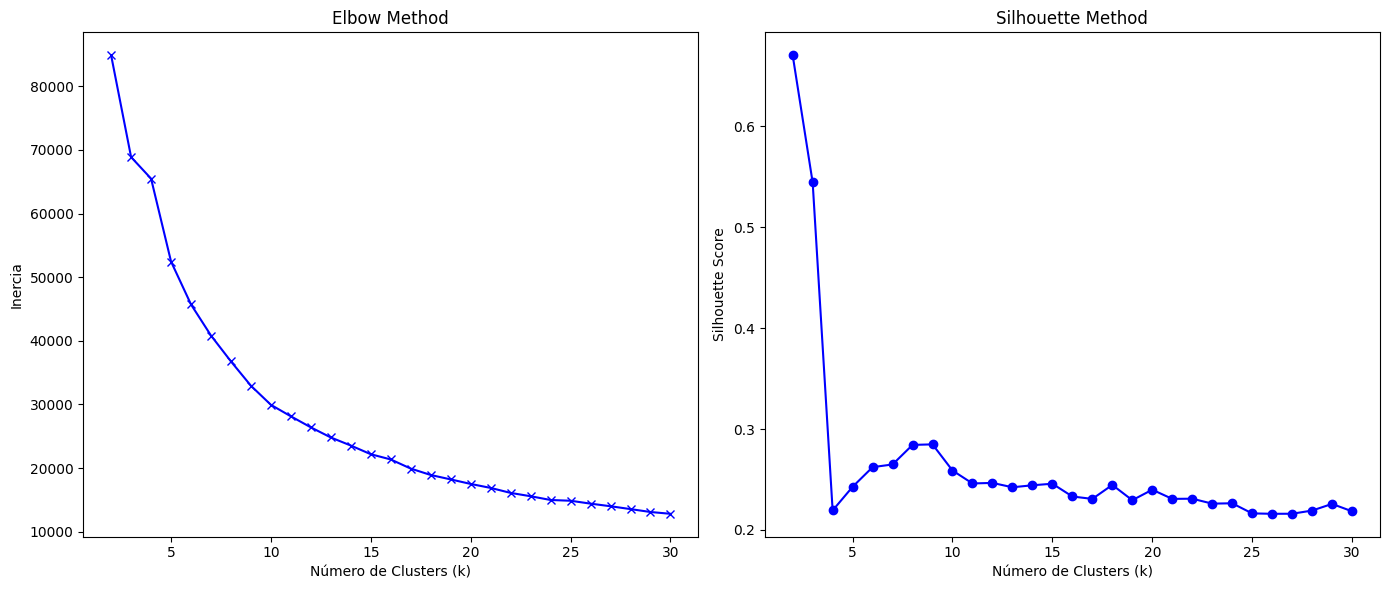

In [14]:
# Elbow and silhouette
km_m.plot_elbow_silhouette(scaled_df, 30)

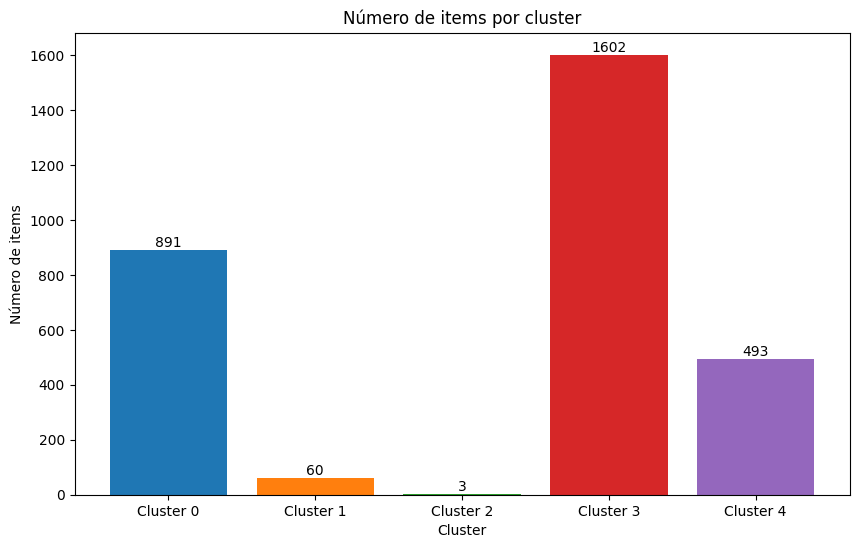

MAX(sales.raw_earn)  MAX(sales.units)  MEAN(sales.raw_earn)  \
item                                                                            
ACCESORIES_1_001              65.9148               6.0             15.315095   
ACCESORIES_1_002              31.6806               6.0              6.694430   
ACCESORIES_1_003              23.7006               6.0              4.806321   
ACCESORIES_1_004             123.4240              20.0             21.065210   
ACCESORIES_1_005              34.4736               9.0              6.509380   

                  MEAN(sales.units)  MIN(sales.raw_earn)  STD(sales.raw_earn)  \
item                                                                            
ACCESORIES_1_001           1.393241               6.6500             7.921939   
ACCESORIES_1_002           1.268571               2.6600             3.270445   
ACCESORIES_1_003           1.220238               1.2901             2.159986   
ACCESORIES_1_004           3.413471               6.1712            17.589802   
ACCESORIES_1_005           1.704463               2.6600             3.881594   

                  STD(sales.units)  SUM(sales.raw_earn)  \
item                                                      
ACCESORIES_1_001          0.720229           38517.4650   
ACCESORIES_1_002          0.618826           11715.2518   
ACCESORIES_1_003          0.548854            5652.2340   
ACCESORIES_1_004          2.850305          110402.7680   
ACCESORIES_1_005          1.010506           25087.1516   

                  MAX(sales.PERCENTILE(raw_earn))  \
item                                                
ACCESORIES_1_001                         0.984823   
ACCESORIES_1_002                         0.933045   
ACCESORIES_1_003                         0.889363   
ACCESORIES_1_004                         0.996682   
ACCESORIES_1_005                         0.942635   

                  MAX(sales.PERCENTILE(units))  ...  \
item                                            ...   
ACCESORIES_1_001                      0.883327  ...   
ACCESORIES_1_002                      0.883327  ...   
ACCESORIES_1_003                      0.883327  ...   
ACCESORIES_1_004                      0.985091  ...   
ACCESORIES_1_005                      0.937677  ...   

                  SUM(sales.PERCENTILE(raw_earn))  \
item                                                
ACCESORIES_1_001                      1857.415016   
ACCESORIES_1_002                       749.350268   
ACCESORIES_1_003                       360.562173   
ACCESORIES_1_004                      3793.316458   
ACCESORIES_1_005                      1551.616192   

                  SUM(sales.PERCENTILE(units))  \
item                                             
ACCESORIES_1_001                    821.290270   
ACCESORIES_1_002                    511.909244   
ACCESORIES_1_003                    329.195805   
ACCESORIES_1_004                   3046.876197   
ACCESORIES_1_005                   1521.452324   

                  PERCENTILE(MAX(sales.raw_earn))  \
item                                                
ACCESORIES_1_001                         0.597573   
ACCESORIES_1_002                         0.175139   
ACCESORIES_1_003                         0.079862   
ACCESORIES_1_004                         0.865530   
ACCESORIES_1_005                         0.205969   

                  PERCENTILE(MAX(sales.units))  PERCENTILE(MEAN(sales.units))  \
item                                                                            
ACCESORIES_1_001                      0.137258                       0.250246   
ACCESORIES_1_002                      0.137258                       0.148901   
ACCESORIES_1_003                      0.137258                       0.109216   
ACCESORIES_1_004                      0.719908                       0.858314   
ACCESORIES_1_005                      0.326992                       0.477206   

                  PERCENTILE(MIN(sales.raw_earn

In [15]:
optimal_k = 5 # 4 0 5 compromiso entre ambos graficos

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

## Analisis

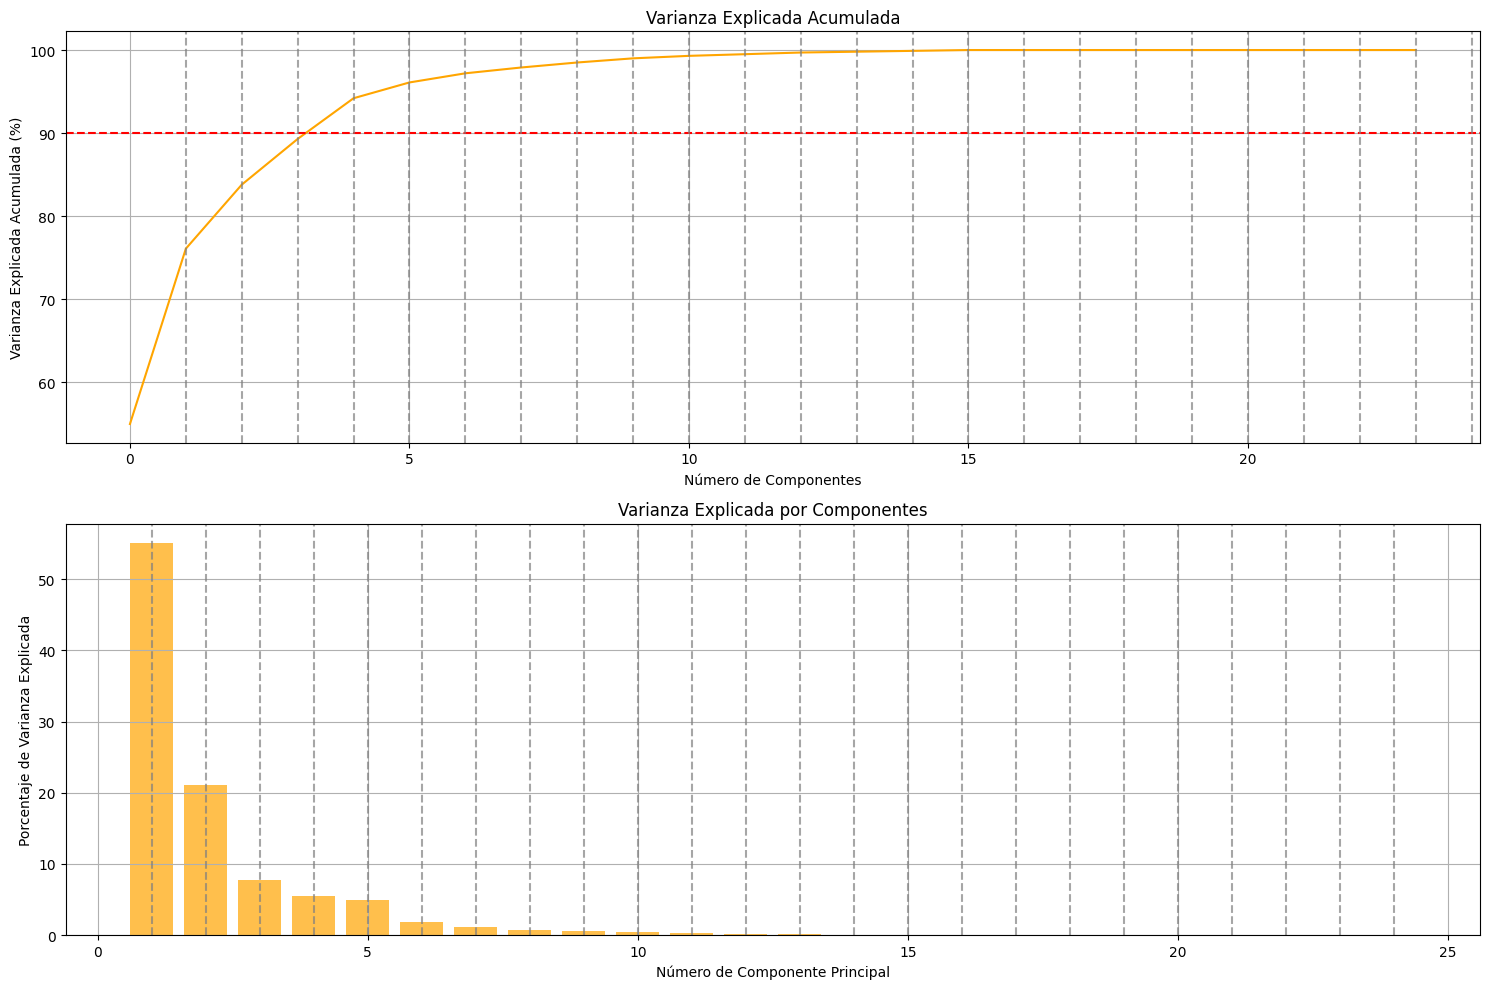

Varianza explicada por cada componente (%): [55.  21.1  7.7  5.5  4.9  1.9  1.1  0.7  0.6  0.5  0.3  0.2  0.2  0.1
  0.1  0.1  0.   0.   0.   0.   0.   0.   0.   0. ]


Componente 1  Componente 2  Componente 3  Componente 4  Componente 5  \
0          55.0          76.1          83.8          89.3          94.2   

   Componente 6  Componente 7  Componente 8  Componente 9  Componente 10  ...  \
0          96.1          97.2          97.9          98.5           99.0  ...   

   Componente 15  Componente 16  Componente 17  Componente 18  Componente 19  \
0           99.9          100.0          100.0          100.0          100.0   

   Componente 20  Componente 21  Componente 22  Componente 23  Componente 24  
0          100.0          100.0          100.0          100.0          100.0  

[1 rows x 24 columns]

In [16]:
# Vemos varianza acumulada en componentes principales
variance_ratio = km_m.view_pca_variance(scaled_df)

acc_var = km_m.calculate_accumulated_variance(variance_ratio)

display(acc_var)

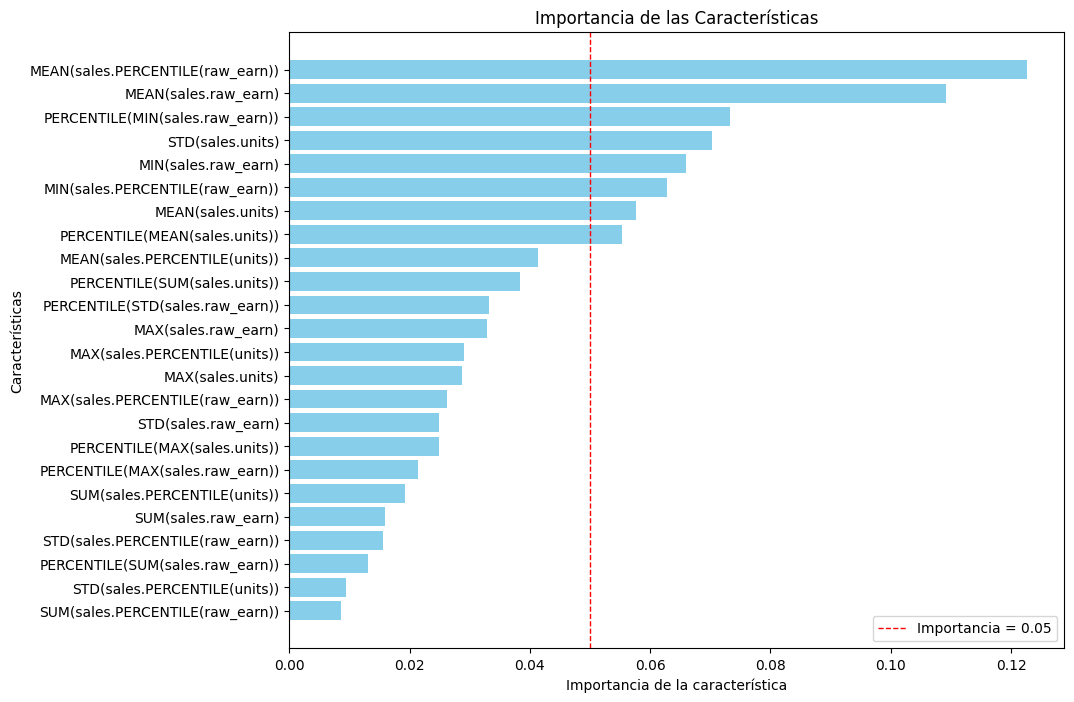

In [17]:
# Importancia de caracteristicas
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([scaled_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

# Seleccionamos solo las caracteristicas que tienen importancia por encima o igual del umbral
selected_features = importance_df[importance_df['Importance'] >= IMPORTANCE_THRES]

# Creamos una lista con las features más importantes usando la columna feature de importance_df
most_important_features = selected_features['Feature'].tolist()

# display(importance_df.head(10))

## Dim redux

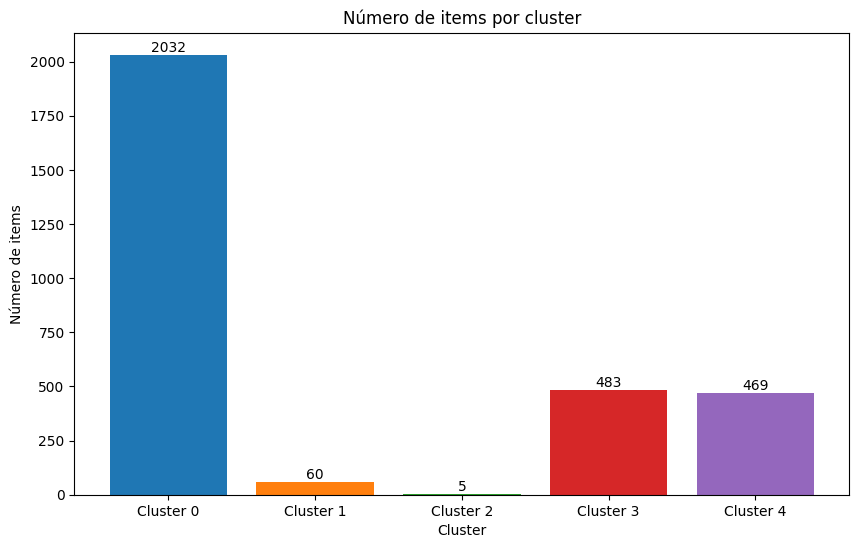

In [18]:
# Ejecutar PCA y clustering
n_components = 5 # Segun visto en varianza acumulada -> casi 95%

# Obtenemos scaled df con componentes y clusters
df_with_pca, loadings_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# # Mostrar el DataFrame con PCA y clustering
# display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

## Descripcion

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

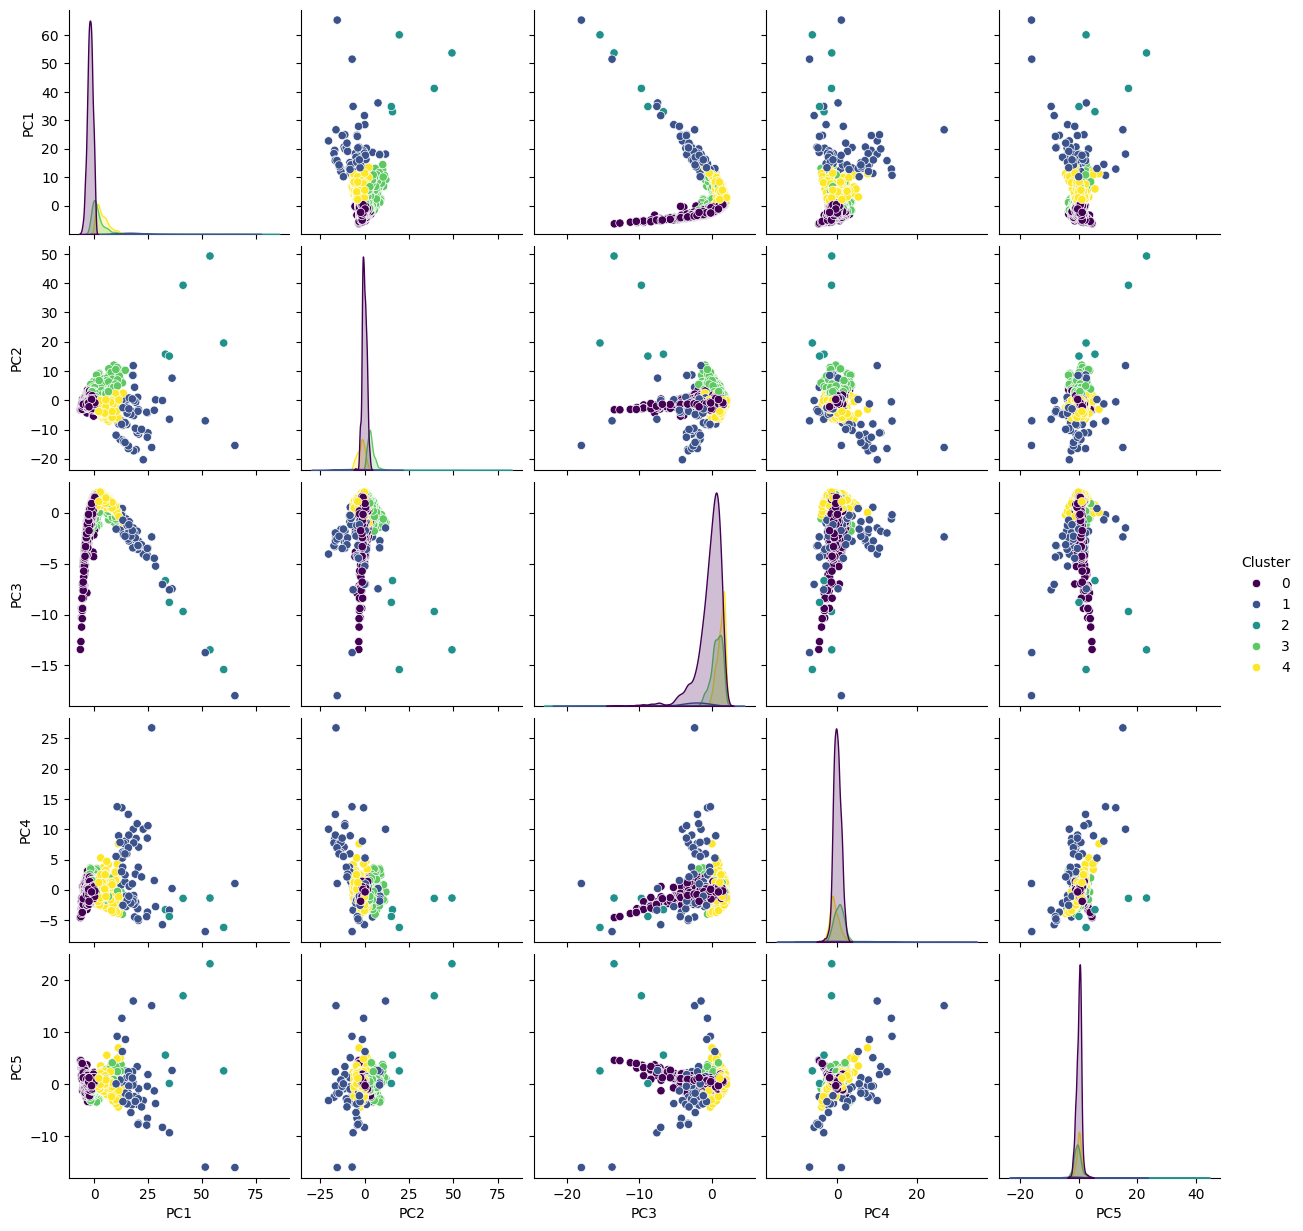

In [19]:
# Visualizacion clusters
cols = n_components + 1 # -> Seleccionamos solo las columnas de PC + Cluster
df_pairplot = df_with_pca.iloc[:, -(cols):]

df_pairplot['Cluster'] = df_with_pca['Cluster']
sns.pairplot(df_pairplot[0:], hue='Cluster', palette='viridis')

**Analisis**  

El gráfico muestra que el clustering tiene una separación razonable entre los grupos, con algunas combinaciones de componentes mostrando separación clara. Esto valida, en general, que las componentes principales están capturando adecuadamente la variabilidad de los datos para el propósito de clustering.

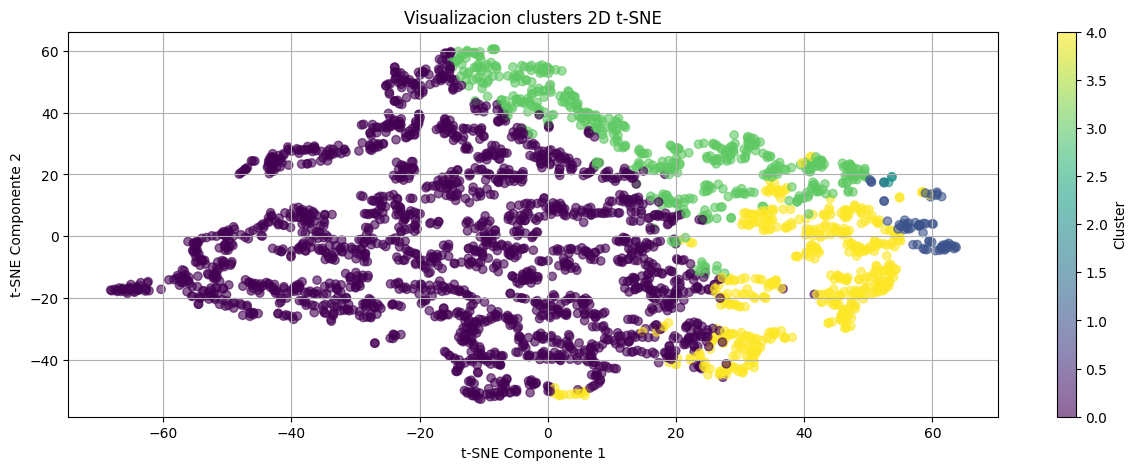

In [20]:
# T SNE visualizacion de clusters
'''
DOC
https://medium.com/@jwbtmf/visualizing-data-using-k-means-clustering-unsupervised-machine-learning-8b59eabfcd3d
'''

km_m.tsne_visualization(df_pairplot, n_components=2, perplexity=30)

In [21]:
# Seleccionamos las features según la lista most_important_features obtenida con random forest
importance_df_filt = importance_df[importance_df['Feature'].isin(most_important_features)]

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
# Ordenamos columnas de description_df usando sort
description_df = description_df[sorted(description_df.columns)]
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


0          1          2         3  \
MEAN(sales.PERCENTILE(raw_earn)) -0.188304   0.502350   1.591820  0.998981   
MEAN(sales.raw_earn)             -0.120210   2.978340  21.197305  2.005696   
PERCENTILE(MIN(sales.raw_earn))  -0.039689  -0.542774   0.667697  0.672285   
STD(sales.units)                 -0.073452  10.548940  10.241777  0.213714   
MIN(sales.raw_earn)               0.154712  -0.297986   2.796091  1.629592   
MIN(sales.PERCENTILE(raw_earn))   0.140205  -0.241338   1.219432  1.119682   
MEAN(sales.units)                -0.067923  11.833520  11.340078  0.275707   
PERCENTILE(MEAN(sales.units))    -0.213937   0.939294   0.953412  0.018861   

                                         4  
MEAN(sales.PERCENTILE(raw_earn))  0.008070  
MEAN(sales.raw_earn)              0.353673  
PERCENTILE(MIN(sales.raw_earn))  -0.458075  
STD(sales.units)                  2.489467  
MIN(sales.raw_earn)              -0.273532  
MIN(sales.PERCENTILE(raw_earn))  -0.246002  
MEAN(sales.units)                 2.757995  
PERCENTILE(MEAN(sales.units))     0.777155

In [22]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

item    category    department  Cluster
0  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1        0
1  ACCESORIES_1_002  ACCESORIES  ACCESORIES_1        0
2  ACCESORIES_1_003  ACCESORIES  ACCESORIES_1        0
3  ACCESORIES_1_004  ACCESORIES  ACCESORIES_1        3
4  ACCESORIES_1_005  ACCESORIES  ACCESORIES_1        0

In [23]:
# Crear dataframe con las descripciones de los clusters
# Daily sales
cluster_summary = {
    0: {
        'cluster_name': 'Productos de Bajo Rendimiento',
        'description': 'Productos con un rendimiento en ventas inferior al promedio. Presentan fluctuaciones mínimas tanto en unidades vendidas como en ingresos generados, lo que indica una baja demanda constante en el tiempo.'
    },
    1: {
        'cluster_name': 'Productos con Volatilidad Moderada',
        'description': 'Productos con rendimiento fluctuante, pero que generan ingresos moderados. La cantidad de unidades vendidas varía significativamente, lo que sugiere que estos productos experimentan picos ocasionales en ventas.'
    },
    2: {
        'cluster_name': 'Productos de Alto Rendimiento y Alta Volatilidad',
        'description': 'Productos con un alto rendimiento en ventas y una considerable variabilidad en las unidades vendidas. Estos productos suelen generar ingresos elevados, pero muestran una alta sensibilidad a factores externos, como promociones o estacionalidad.'
    },
    3: {
        'cluster_name': 'Productos de Rendimiento Estable con Buenas Ventas',
        'description': 'Productos que generan ingresos superiores a la media, con una estabilidad en la cantidad de unidades vendidas. Estos productos muestran una consistencia en su rendimiento, siendo una apuesta segura para mantener en inventario.'
    },
    4: {
        'cluster_name': 'Productos de Bajo Rendimiento con Variabilidad Moderada',
        'description': 'Productos que generan ingresos bajos, pero con una leve variabilidad en las unidades vendidas. Estos productos pueden experimentar pequeños aumentos en ventas en momentos puntuales, pero en general tienen una demanda reducida.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

item    category    department  Cluster  \
0  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1        0   
1  ACCESORIES_1_002  ACCESORIES  ACCESORIES_1        0   
2  ACCESORIES_1_003  ACCESORIES  ACCESORIES_1        0   
3  ACCESORIES_1_004  ACCESORIES  ACCESORIES_1        3   
4  ACCESORIES_1_005  ACCESORIES  ACCESORIES_1        0   

                                        cluster_name  \
0                      Productos de Bajo Rendimiento   
1                      Productos de Bajo Rendimiento   
2                      Productos de Bajo Rendimiento   
3  Productos de Rendimiento Estable con Buenas Ve...   
4                      Productos de Bajo Rendimiento   

                                         description  
0  Productos con un rendimiento en ventas inferio...  
1  Productos con un rendimiento en ventas inferio...  
2  Productos con un rendimiento en ventas inferio...  
3  Productos que generan ingresos superiores a la...  
4  Productos con un rendimiento en ventas inferio...

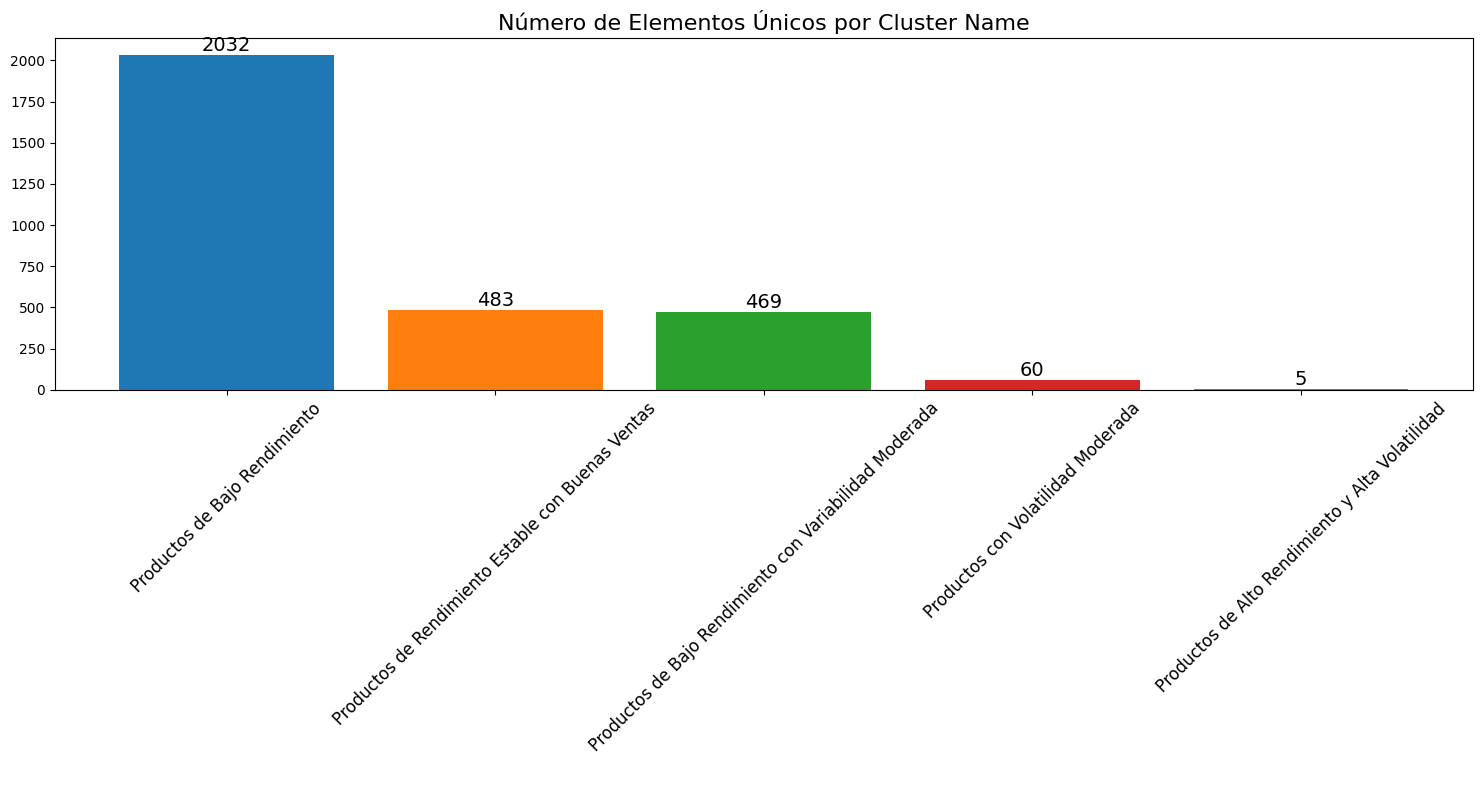

In [24]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos csv

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_raw_earn.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **PRODUCTOS: RANGO DE PRECIOS**
___
___

## Selección caracteristicas

In [25]:
# V3
substrings = ['sell_price'] # Nos quedamos solo con las que afectan al precio de venta

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length Feats Selected: 15
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 15
Shape after filtering: 10
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


MAX(sales.sell_price)  MIN(sales.sell_price)  \
item                                                             
ACCESORIES_1_001                11.4646                 6.6500   
ACCESORIES_1_002                 5.2801                 2.6600   
ACCESORIES_1_003                 3.9501                 1.2502   
ACCESORIES_1_004                 6.1712                 6.1712   
ACCESORIES_1_005                 4.0964                 2.6600   

                  STD(sales.sell_price)  SUM(sales.sell_price)  \
item                                                             
ACCESORIES_1_001               0.155606             27643.8904   
ACCESORIES_1_002               0.094061              9233.6048   
ACCESORIES_1_003               0.135582              4637.2578   
ACCESORIES_1_004               0.000000             32343.2592   
ACCESORIES_1_005               0.143314             14705.5839   

                  MAX(sales.PERCENTILE(sell_price))  \
item                                                  
ACCESORIES_1_001                           0.936978   
ACCESORIES_1_002                           0.698160   
ACCESORIES_1_003                           0.564020   
ACCESORIES_1_004                           0.757854   
ACCESORIES_1_005                           0.569965   

                  MIN(sales.PERCENTILE(sell_price))  \
item                                                  
ACCESORIES_1_001                           0.795620   
ACCESORIES_1_002                           0.321503   
ACCESORIES_1_003                           0.119489   
ACCESORIES_1_004                           0.757854   
ACCESORIES_1_005                           0.321503   

                  STD(sales.PERCENTILE(sell_price))  \
item                                                  
ACCESORIES_1_001                           0.004588   
ACCESORIES_1_002                           0.013125   
ACCESORIES_1_003                           0.022375   
ACCESORIES_1_004                           0.000000   
ACCESORIES_1_005                           0.015901   

                  SUM(sales.PERCENTILE(sell_price))  \
item                                                  
ACCESORIES_1_001                        2333.014799   
ACCESORIES_1_002                        1220.891721   
ACCESORIES_1_003                         661.957740   
ACCESORIES_1_004                        3971.911419   
ACCESORIES_1_005                        2114.597356   

                  PERCENTILE(STD(sales.sell_price))  \
item                                                  
ACCESORIES_1_001                           0.696622   
ACCESORIES_1_002                           0.564775   
ACCESORIES_1_003                           0.661200   
ACCESORIES_1_004                           0.126107   
ACCESORIES_1_005                           0.675631   

                  PERCENTILE(SUM(sales.sell_price))  
item                                                 
ACCESORIES_1_001                           0.878321  
ACCESORIES_1_002                           0.383076  
ACCESORIES_1_003                           0.115776  
ACCESORIES_1_004                           0.914726  
ACCESORIES_1_005                           0.623811

## Preprocesamiento

In [26]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 10


## Kmeans

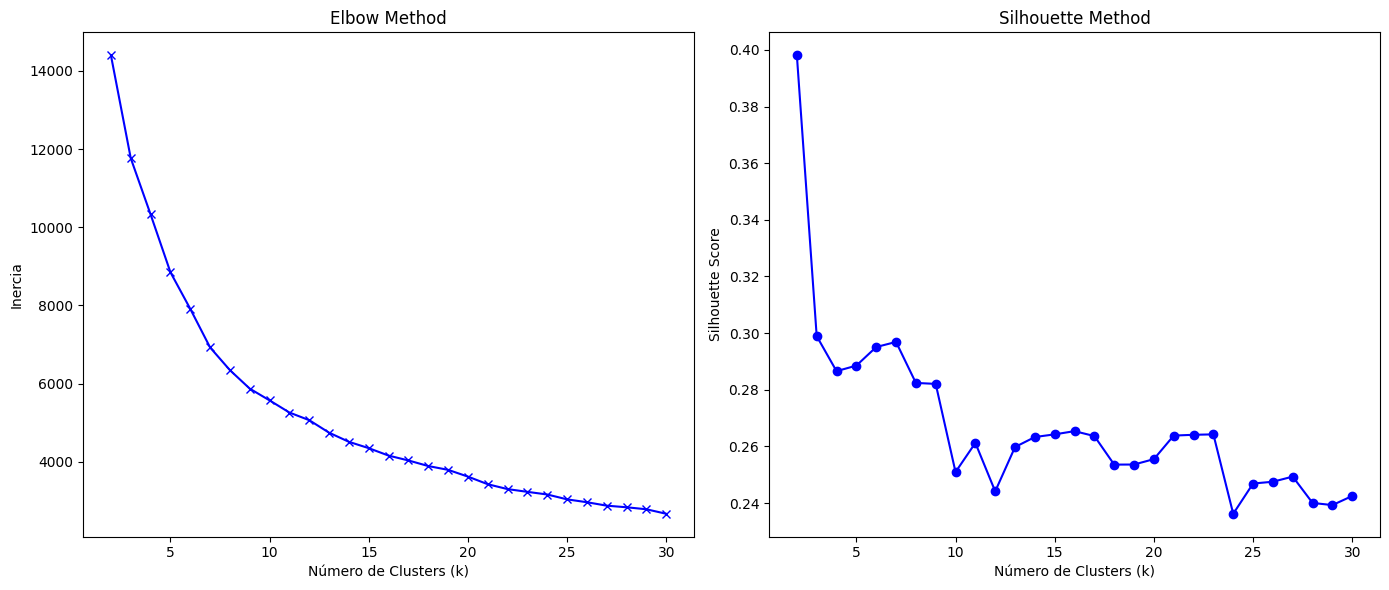

In [27]:
km_m.plot_elbow_silhouette(scaled_df, 30)

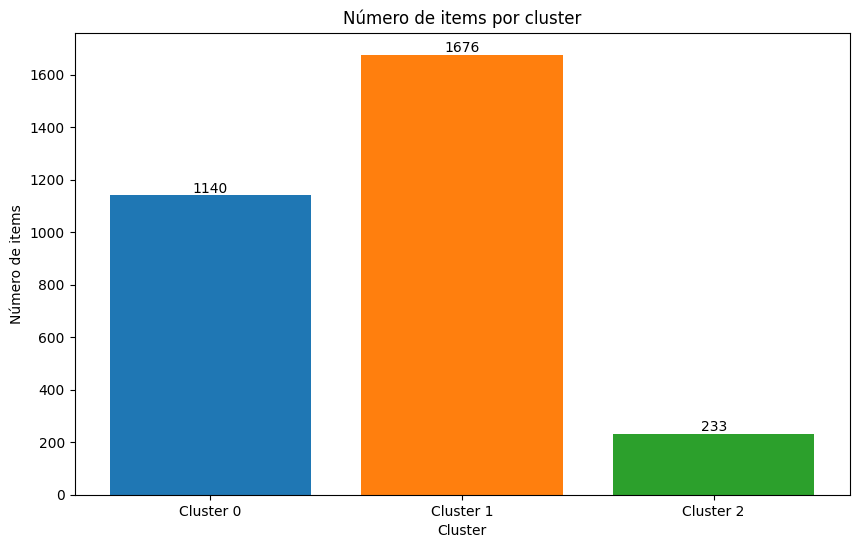

MAX(sales.sell_price)  MIN(sales.sell_price)  \
item                                                             
ACCESORIES_1_001                11.4646                 6.6500   
ACCESORIES_1_002                 5.2801                 2.6600   
ACCESORIES_1_003                 3.9501                 1.2502   
ACCESORIES_1_004                 6.1712                 6.1712   
ACCESORIES_1_005                 4.0964                 2.6600   

                  STD(sales.sell_price)  SUM(sales.sell_price)  \
item                                                             
ACCESORIES_1_001               0.155606             27643.8904   
ACCESORIES_1_002               0.094061              9233.6048   
ACCESORIES_1_003               0.135582              4637.2578   
ACCESORIES_1_004               0.000000             32343.2592   
ACCESORIES_1_005               0.143314             14705.5839   

                  MAX(sales.PERCENTILE(sell_price))  \
item                                                  
ACCESORIES_1_001                           0.936978   
ACCESORIES_1_002                           0.698160   
ACCESORIES_1_003                           0.564020   
ACCESORIES_1_004                           0.757854   
ACCESORIES_1_005                           0.569965   

                  MIN(sales.PERCENTILE(sell_price))  \
item                                                  
ACCESORIES_1_001                           0.795620   
ACCESORIES_1_002                           0.321503   
ACCESORIES_1_003                           0.119489   
ACCESORIES_1_004                           0.757854   
ACCESORIES_1_005                           0.321503   

                  STD(sales.PERCENTILE(sell_price))  \
item                                                  
ACCESORIES_1_001                           0.004588   
ACCESORIES_1_002                           0.013125   
ACCESORIES_1_003                           0.022375   
ACCESORIES_1_004                           0.000000   
ACCESORIES_1_005                           0.015901   

                  SUM(sales.PERCENTILE(sell_price))  \
item                                                  
ACCESORIES_1_001                        2333.014799   
ACCESORIES_1_002                        1220.891721   
ACCESORIES_1_003                         661.957740   
ACCESORIES_1_004                        3971.911419   
ACCESORIES_1_005                        2114.597356   

                  PERCENTILE(STD(sales.sell_price))  \
item                                                  
ACCESORIES_1_001                           0.696622   
ACCESORIES_1_002                           0.564775   
ACCESORIES_1_003                           0.661200   
ACCESORIES_1_004                           0.126107   
ACCESORIES_1_005                           0.675631   

                  PERCENTILE(SUM(sales.sell_price))  Cluster  
item                                                          
ACCESORIES_1_001                           0.878321        0  
ACCESORIES_1_002                           0.383076        1  
ACCESORIES_1_003                           0.115776        1  
ACCESORIES_1_004                           0.914726        0  
ACCESORIES_1_005                           0.623811        1

In [28]:
optimal_k = 3 # 3 o 5 -> con 5 aparecian bastantes solapamientos en los pairplots

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

## Analisis

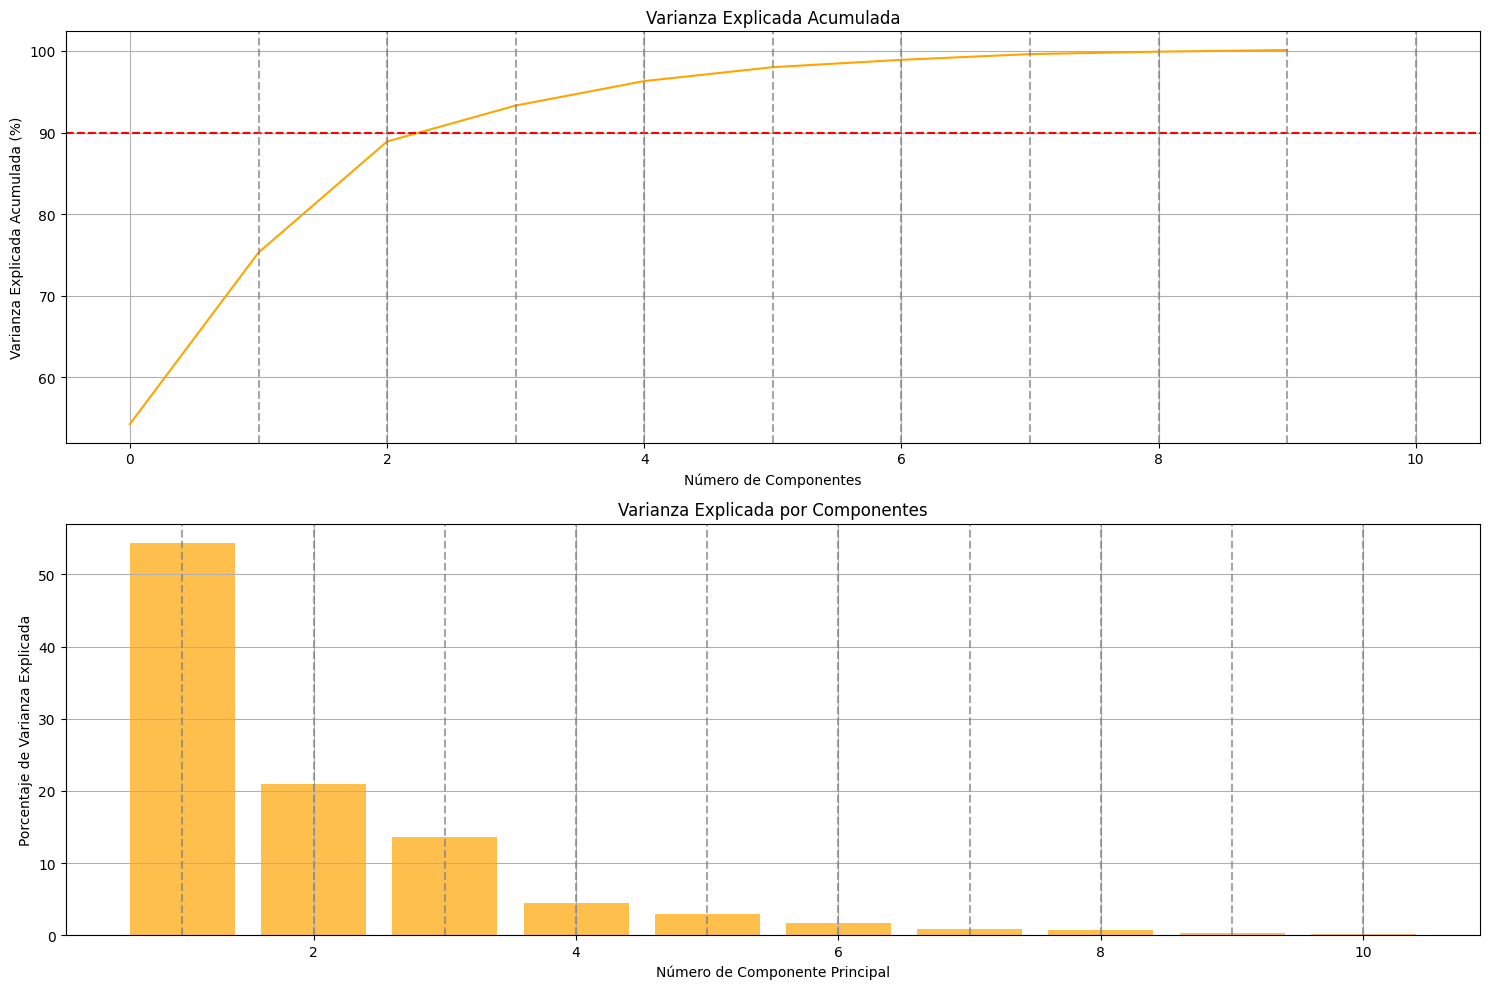

Varianza explicada por cada componente (%): [54.3 21.  13.6  4.4  3.   1.7  0.9  0.7  0.3  0.2]


Componente 1  Componente 2  Componente 3  Componente 4  Componente 5  \
0          54.3          75.3          88.9          93.3          96.3   

   Componente 6  Componente 7  Componente 8  Componente 9  Componente 10  
0          98.0          98.9          99.6          99.9          100.1

In [29]:
variance_ratio = km_m.view_pca_variance(scaled_df)

acc_var = km_m.calculate_accumulated_variance(variance_ratio)

display(acc_var)

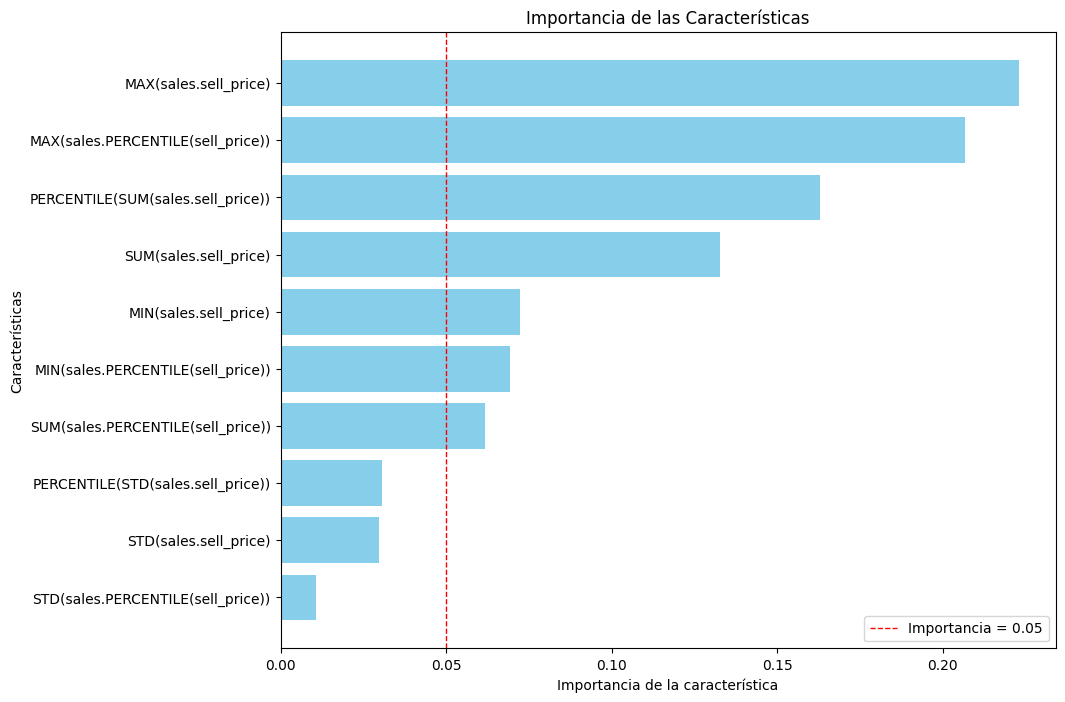

In [30]:
# Importancia de caracteristicas
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([scaled_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

# Seleccionamos solo las caracteristicas que tienen importancia por encima o igual del umbral
selected_features = importance_df[importance_df['Importance'] >= IMPORTANCE_THRES]

# Creamos una lista con las features más importantes usando la columna feature de importance_df
most_important_features = selected_features['Feature'].tolist()

# display(importance_df.head(10))

## Dim Redux

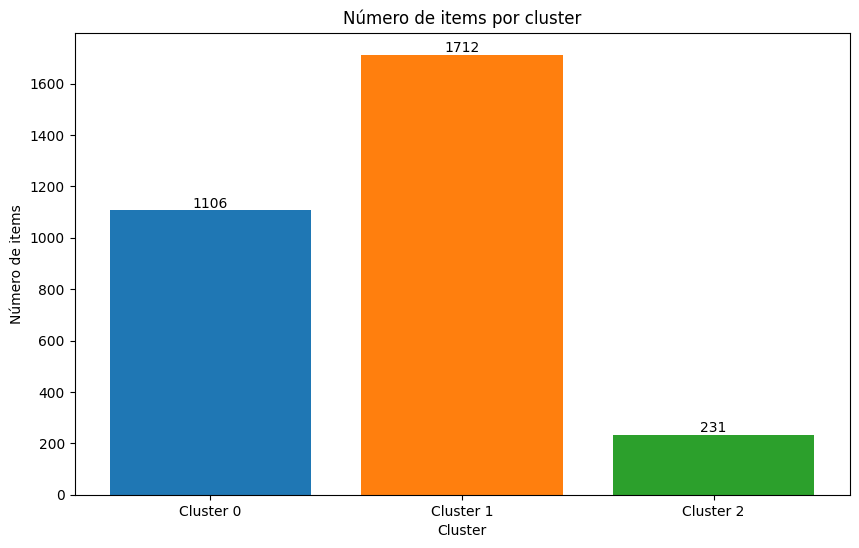

In [32]:
# Ejecutar PCA y clustering
n_components = 4 # Segun visto en varianza acumulada -> casi 90%

# Obtenemos scaled df con componentes y clusters
df_with_pca, loadings_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# # Mostrar el DataFrame con PCA y clustering
# display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

## Descripcion de los clusters

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

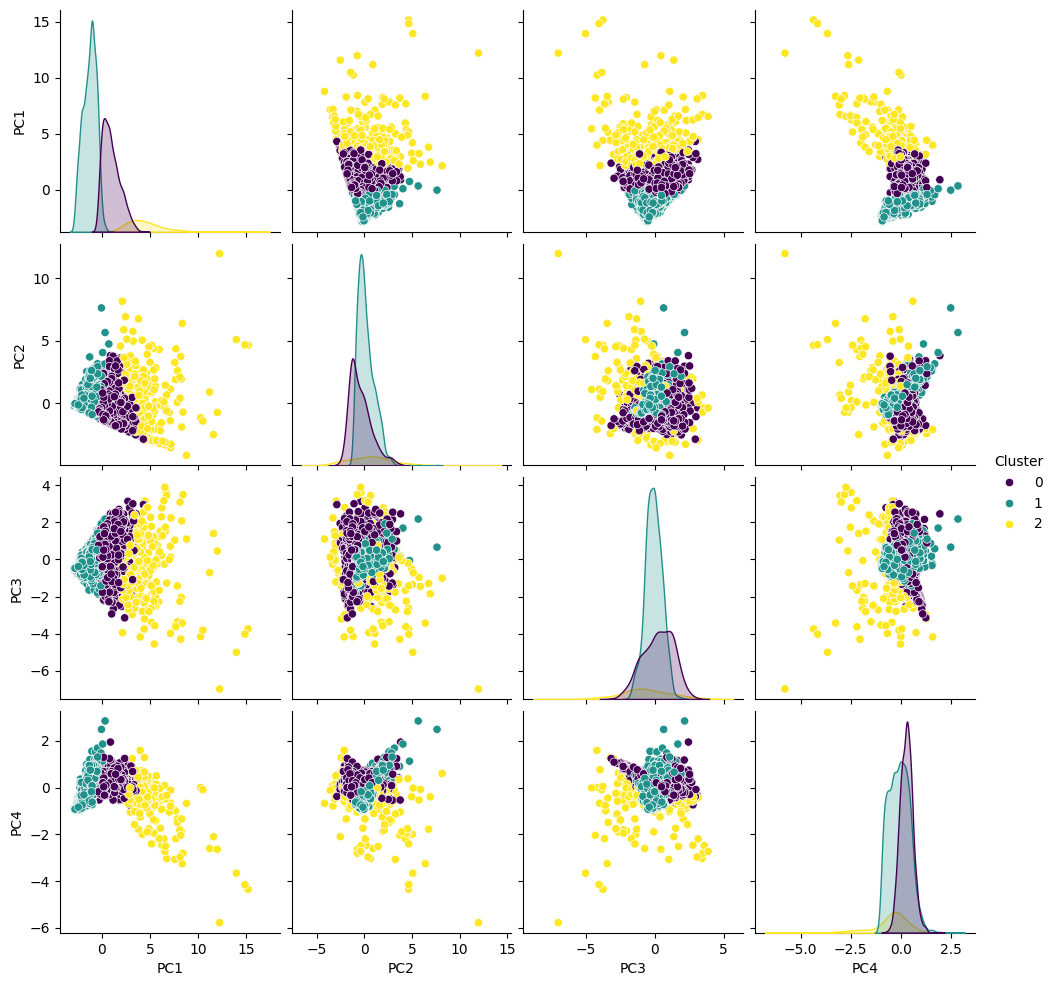

In [33]:
# Visualizacion clusters
cols = n_components + 1 # -> Seleccionamos solo las columnas de PC y Cluster
df_pairplot = df_with_pca.iloc[:, -(cols):]

# display(df_pairplot.head())

df_pairplot['Cluster'] = df_with_pca['Cluster']
sns.pairplot(df_pairplot[0:], hue='Cluster', palette='viridis')

**Analisis**  
  
El PC1 separa muy bien con el resto de componentes. Podriamos quedarnos con 2 seguramente.

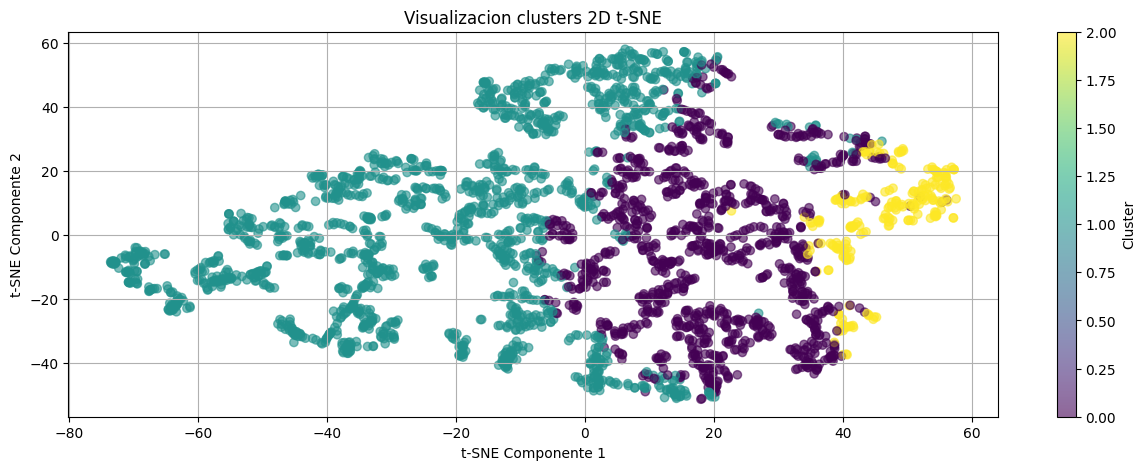

In [34]:
# T SNE visualizacion de clusters
km_m.tsne_visualization(df_pairplot, n_components=2, perplexity=30)

Mostrar Descripcions

In [35]:
# Seleccionamos las features según la lista most_important_features obtenida con random forest
importance_df_filt = importance_df[importance_df['Feature'].isin(most_important_features)]

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
# Ordenamos columnas de description_df usando sort
description_df = description_df[sorted(description_df.columns)]
display(description_df)

###########################################################
Descripcion de los clusters
###########################################################


0         1         2
MAX(sales.sell_price)              0.657081 -0.255314  2.798131
MAX(sales.PERCENTILE(sell_price))  0.372193 -0.426302  0.738776
PERCENTILE(SUM(sales.sell_price))  0.438244 -0.381264  0.727389
SUM(sales.sell_price)              0.780329 -0.286602  2.457584
MIN(sales.sell_price)              0.707497 -0.184243  2.275366
MIN(sales.PERCENTILE(sell_price))  0.476438 -0.236950  0.850615
SUM(sales.PERCENTILE(sell_price))  0.736117 -0.281041  0.832857

Asignacion clusters a items

In [36]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

item    category    department  Cluster
0  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1        0
1  ACCESORIES_1_002  ACCESORIES  ACCESORIES_1        1
2  ACCESORIES_1_003  ACCESORIES  ACCESORIES_1        1
3  ACCESORIES_1_004  ACCESORIES  ACCESORIES_1        0
4  ACCESORIES_1_005  ACCESORIES  ACCESORIES_1        1

In [37]:
# Crear dataframe con las descripciones de los clusters
# Daily sales
cluster_summary = {
    0: {
        'cluster_name': 'Productos de Precio Medio-Alto',
        'description': 'Productos con precios que tienden a ubicarse en el rango medio-alto del mercado. Aunque no llegan a los precios más elevados, muestran consistencia en su valor con pocas fluctuaciones hacia abajo.'
    },
    1: {
        'cluster_name': 'Productos de Precio Bajo o Descontado',
        'description': 'Productos que generalmente se venden a precios bajos o que podrían haber experimentado descuentos. Estos productos tienen una tendencia a ubicarse en el extremo inferior del rango de precios, siendo opciones más accesibles para los consumidores.'
    },
    2: {
        'cluster_name': 'Productos de Precio Premium',
        'description': 'Productos con precios consistentemente altos, alcanzando los valores más elevados del mercado. Estos productos se sitúan en el segmento premium, siendo atractivos para consumidores que buscan calidad o exclusividad y reflejando su valor tanto en los precios máximos como mínimos.'
    }
}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

items_with_cluster_info = items_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

item    category    department  cluster  \
0  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1        0   
1  ACCESORIES_1_002  ACCESORIES  ACCESORIES_1        1   
2  ACCESORIES_1_003  ACCESORIES  ACCESORIES_1        1   
3  ACCESORIES_1_004  ACCESORIES  ACCESORIES_1        0   
4  ACCESORIES_1_005  ACCESORIES  ACCESORIES_1        1   

                            cluster_name  \
0         Productos de Precio Medio-Alto   
1  Productos de Precio Bajo o Descontado   
2  Productos de Precio Bajo o Descontado   
3         Productos de Precio Medio-Alto   
4  Productos de Precio Bajo o Descontado   

                                         description  
0  Productos con precios que tienden a ubicarse e...  
1  Productos que generalmente se venden a precios...  
2  Productos que generalmente se venden a precios...  
3  Productos con precios que tienden a ubicarse e...  
4  Productos que generalmente se venden a precios...

Plot clusters con descripcion

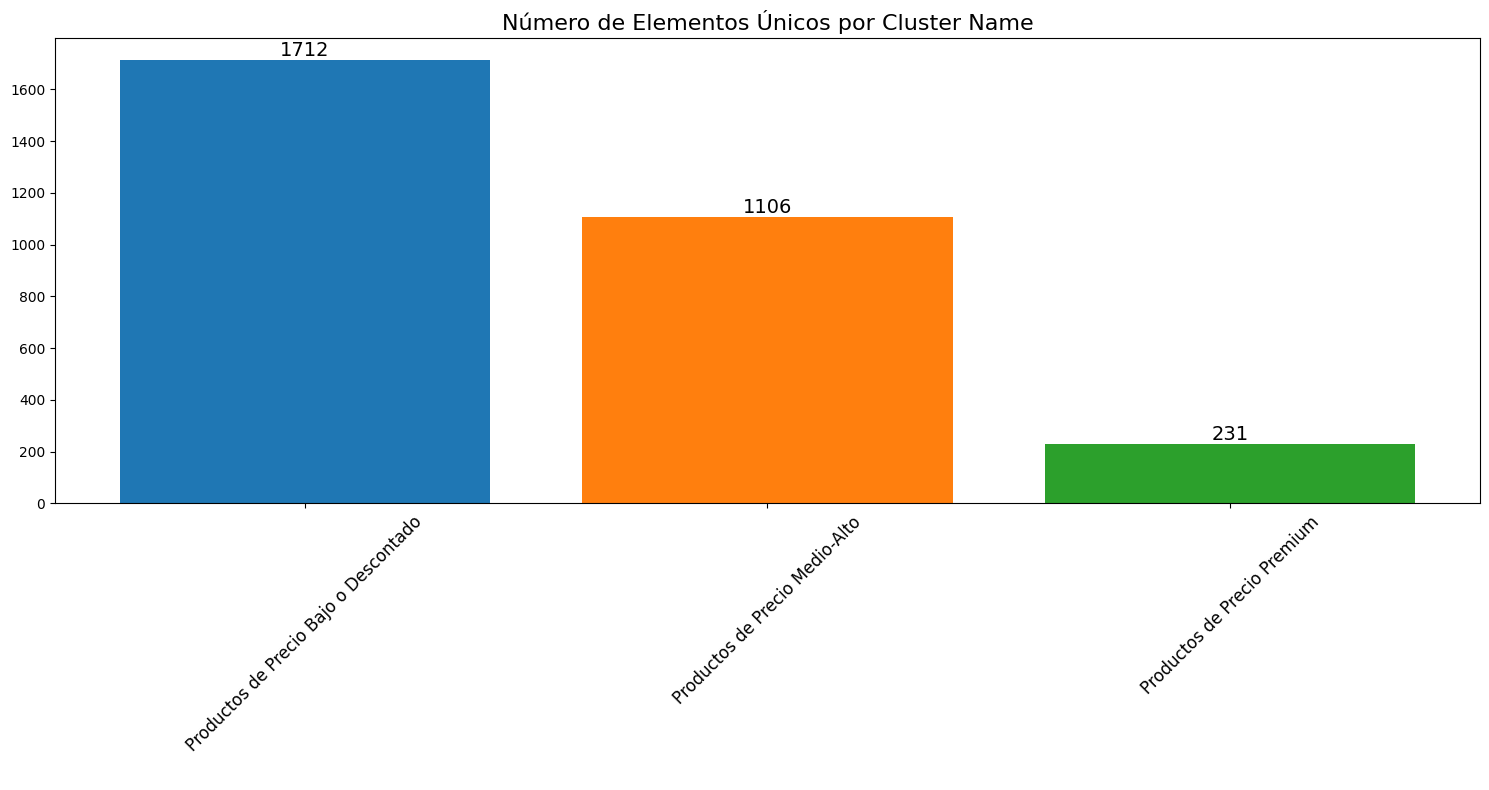

In [38]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_price_range.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **PRODUCTOS: EVENTOS**  
  
**Efecto de eventos en ventas de productos**
___
___

## Creacion caracteristicas

In [39]:
# OHE para columna event en df_ws usando sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder

# Seleccionar la columna 'event' para codificar
events = df_ws[['event']]

# Crear el OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar los eventos con OHE
event_encoded = ohe.fit_transform(events)

# Crear un DataFrame con las columnas codificadas
event_encoded_df = pd.DataFrame(event_encoded, columns=ohe.get_feature_names_out(['event']))

# Concatenar con el DataFrame original de ventas
df_ws_ohe = pd.concat([df_ws.reset_index(drop=True), event_encoded_df], axis=1)

# Ver el resultado
df_ws_ohe.head()


id              item store_code       date  units  year  week  sell_price  \
0   0  ACCESORIES_1_001      NYC_1 2014-01-01      1  2014     1     10.9858   
1   1  ACCESORIES_1_004      NYC_1 2014-01-01      2  2014     1      6.1712   
2   2  ACCESORIES_1_005      NYC_1 2014-01-01      1  2014     1      4.0964   
3   3  ACCESORIES_1_008      NYC_1 2014-01-01      3  2014     1      0.6118   
4   4  ACCESORIES_1_010      NYC_1 2014-01-01      3  2014     1      3.9501   

   raw_earn  month   day_name  weekday_number    event  event_Easter  \
0   10.9858      1  Wednesday               2  NewYear           0.0   
1   12.3424      1  Wednesday               2  NewYear           0.0   
2    4.0964      1  Wednesday               2  NewYear           0.0   
3    1.8354      1  Wednesday               2  NewYear           0.0   
4   11.8503      1  Wednesday               2  NewYear           0.0   

   event_NewYear  event_None  event_Ramadan starts  event_SuperBowl  \
0            1.0         0.0                   0.0              0.0   
1            1.0         0.0                   0.0              0.0   
2            1.0         0.0                   0.0              0.0   
3            1.0         0.0                   0.0              0.0   
4            1.0         0.0                   0.0              0.0   

   event_Thanksgiving  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

In [40]:
import featuretools as ft

# Crear un EntitySet
es = ft.EntitySet(id='sales_data')

# Agregar entidades
es = es.add_dataframe(dataframe_name="items", dataframe=df_items, index="item")
es = es.add_dataframe(dataframe_name="shops", dataframe=df_shops, index="store_code")
es = es.add_dataframe(dataframe_name="sales", dataframe=df_ws_ohe, index="id",
                      time_index="week",
                      secondary_time_index={'year': ['units', 'sell_price', 'raw_earn']})

# Definir relaciones
es = es.add_relationship("items", "item", "sales", "item")
es = es.add_relationship("shops", "store_code", "sales", "store_code")

# Generar características automáticas, ahora centradas en "items"
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="items",  # Objetivo: productos
                                      agg_primitives=[
                                          "sum", "mean", "count"  # Agregación sobre ventas
                                      ],
                                      trans_primitives=["year"],  # Primitivas de transformación, usando 'year'
                                      max_depth=2)

feature_matrix.head()

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

category    department  COUNT(sales)  \
item                                                       
ACCESORIES_1_001  ACCESORIES  ACCESORIES_1          2515   
ACCESORIES_1_002  ACCESORIES  ACCESORIES_1          1750   
ACCESORIES_1_003  ACCESORIES  ACCESORIES_1          1176   
ACCESORIES_1_004  ACCESORIES  ACCESORIES_1          5241   
ACCESORIES_1_005  ACCESORIES  ACCESORIES_1          3854   

                  MEAN(sales.event_Easter)  MEAN(sales.event_NewYear)  \
item                                                                    
ACCESORIES_1_001                  0.003976                   0.002783   
ACCESORIES_1_002                  0.002286                   0.002286   
ACCESORIES_1_003                  0.005952                   0.006803   
ACCESORIES_1_004                  0.003625                   0.004198   
ACCESORIES_1_005                  0.002854                   0.003373   

                  MEAN(sales.event_None)  MEAN(sales.event_Ramadan starts)  \
item                                                                         
ACCESORIES_1_001                0.984891                          0.002386   
ACCESORIES_1_002                0.988000                          0.003429   
ACCESORIES_1_003                0.977041                          0.005102   
ACCESORIES_1_004                0.984163                          0.002480   
ACCESORIES_1_005                0.984172                          0.003373   

                  MEAN(sales.event_SuperBowl)  MEAN(sales.event_Thanksgiving)  \
item                                                                            
ACCESORIES_1_001                     0.003976                        0.001988   
ACCESORIES_1_002                     0.001714                        0.002286   
ACCESORIES_1_003                     0.003401                        0.001701   
ACCESORIES_1_004                     0.003434                        0.002099   
ACCESORIES_1_005                     0.003892                        0.002335   

                  MEAN(sales.month)  ...  SUM(sales.event_Ramadan starts)  \
item                                 ...                                    
ACCESORIES_1_001           6.027833  ...                              6.0   
ACCESORIES_1_002           6.692571  ...                              6.0   
ACCESORIES_1_003           6.060374  ...                              6.0   
ACCESORIES_1_004           5.840870  ...                             13.0   
ACCESORIES_1_005           6.115205  ...                             13.0   

                  SUM(sales.event_SuperBowl)  SUM(sales.event_Thanksgiving)  \
item                                                                          
ACCESORIES_1_001                        10.0                            5.0   
ACCESORIES_1_002                         3.0                            4.0   
ACCESORIES_1_003                         4.0                            2.0   
ACCESORIES_1_004                        18.0                           11.0   
ACCESORIES_1_005                        15.0                            9.0   

                  SUM(sales.month)  SUM(sales.raw_earn)  \
item                                                      
ACCESORIES_1_001           15160.0           38517.4650   
ACCESORIES_1_002           11712.0           11715.2518   
ACCESORIES_1_003            7127.0            5652.2340   
ACCESORIES_1_004           30612.0          110402.7680   
ACCESORIES_1_005           23568.0           25087.1516   

                  SUM(sales.sell_price)  SUM(sales.units)  SUM(sales.week)  \
item                                                                         
ACCESORIES_1_001             27643.8904            3504.0          61813.0   
ACCESORIES_1_002              9233.6048            2220.0          48065.0   
ACCESORIES_1_003              4637.2578            1435.0          29262.0   
ACCESORIES_1_004             32343.2592           17890.0         124913.0

## Selección caracteristicas

In [41]:
# Revision definiciones caracteristicas creadas
features_descriptions = fcm.get_features_descriptions(feature_defs)

display(type(features_descriptions))

display(features_descriptions)

list

['<Feature: category>: The "category".',
 '<Feature: department>: The "department".',
 '<Feature: COUNT(sales)>: The number of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Easter)>: The average of the "event_Easter" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_NewYear)>: The average of the "event_NewYear" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_None)>: The average of the "event_None" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Ramadan starts)>: The average of the "event_Ramadan starts" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_SuperBowl)>: The average of the "event_SuperBowl" of all instances of "sales" for each "item" in "items".',
 '<Feature: MEAN(sales.event_Thanksgiving)>: The average of the "event_Thanksgiving" of all instances of "sales" for each "item" in "items".',


In [42]:
# V3
substrings = ['event', 'raw_earn', 'units']

print(f'Length All features: {len(features_descriptions)}')

feat_selected = fcm.select_features(features_descriptions, substrings)

print(f'Length Feats Selected: {len(feat_selected)}')
# display(feat_selected)

feature_matrix_selected = feature_matrix[feat_selected].copy()

# display(feature_matrix_selected.head(5))

# Aplicar filtros a las caracteristicas creadas
# Remove low information, highly correlated, highly null and single value features
filtered_feature_matrix = fcm.filter_feature_matrix(feature_matrix_selected)

# Renombrar características si es necesario # Evitamos este paso de momento
# feature_matrix_renamed = fcm.rename_features(filtered_feature_matrix, price_range_features)
feature_matrix_renamed = filtered_feature_matrix.copy()

display(feature_matrix_renamed.head(5))

Length All features: 29
Length Feats Selected: 16
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Shape before filtering: 16
Shape after filtering: 15
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


MEAN(sales.event_Easter)  MEAN(sales.event_NewYear)  \
item                                                                    
ACCESORIES_1_001                  0.003976                   0.002783   
ACCESORIES_1_002                  0.002286                   0.002286   
ACCESORIES_1_003                  0.005952                   0.006803   
ACCESORIES_1_004                  0.003625                   0.004198   
ACCESORIES_1_005                  0.002854                   0.003373   

                  MEAN(sales.event_None)  MEAN(sales.event_Ramadan starts)  \
item                                                                         
ACCESORIES_1_001                0.984891                          0.002386   
ACCESORIES_1_002                0.988000                          0.003429   
ACCESORIES_1_003                0.977041                          0.005102   
ACCESORIES_1_004                0.984163                          0.002480   
ACCESORIES_1_005                0.984172                          0.003373   

                  MEAN(sales.event_SuperBowl)  MEAN(sales.event_Thanksgiving)  \
item                                                                            
ACCESORIES_1_001                     0.003976                        0.001988   
ACCESORIES_1_002                     0.001714                        0.002286   
ACCESORIES_1_003                     0.003401                        0.001701   
ACCESORIES_1_004                     0.003434                        0.002099   
ACCESORIES_1_005                     0.003892                        0.002335   

                  MEAN(sales.raw_earn)  MEAN(sales.units)  \
item                                                        
ACCESORIES_1_001             15.315095           1.393241   
ACCESORIES_1_002              6.694430           1.268571   
ACCESORIES_1_003              4.806321           1.220238   
ACCESORIES_1_004             21.065210           3.413471   
ACCESORIES_1_005              6.509380           1.704463   

                  SUM(sales.event_Easter)  SUM(sales.event_NewYear)  \
item                                                                  
ACCESORIES_1_001                     10.0                       7.0   
ACCESORIES_1_002                      4.0                       4.0   
ACCESORIES_1_003                      7.0                       8.0   
ACCESORIES_1_004                     19.0                      22.0   
ACCESORIES_1_005                     11.0                      13.0   

                  SUM(sales.event_None)  SUM(sales.event_Ramadan starts)  \
item                                                                       
ACCESORIES_1_001                 2477.0                              6.0   
ACCESORIES_1_002                 1729.0                              6.0   
ACCESORIES_1_003                 1149.0                              6.0   
ACCESORIES_1_004                 5158.0                             13.0   
ACCESORIES_1_005                 3793.0                             13.0   

                  SUM(sales.event_SuperBowl)  SUM(sales.event_Thanksgiving)  \
item                                                                          
ACCESORIES_1_001                        10.0                            5.0   
ACCESORIES_1_002                         3.0                            4.0   
ACCESORIES_1_003                         4.0                            2.0   
ACCESORIES_1_004                        18.0                           11.0   
ACCESORIES_1_005                        15.0                            9.0   

                  SUM(sales.raw_earn)  
item                                   
ACCESORIES_1_001           38517.4650  
ACCESORIES_1_002           11715.2518  
ACCESORIES_1_003            5652.2340  
ACCESORIES_1_004          110402.7680  
ACCESORIES_1_005           25087.1516

## Preprocesamiento

In [43]:
scaled_df = pm.preprocess_features(feature_matrix_renamed)

Cat cols: 0
Num cols: 15


## Kmeans

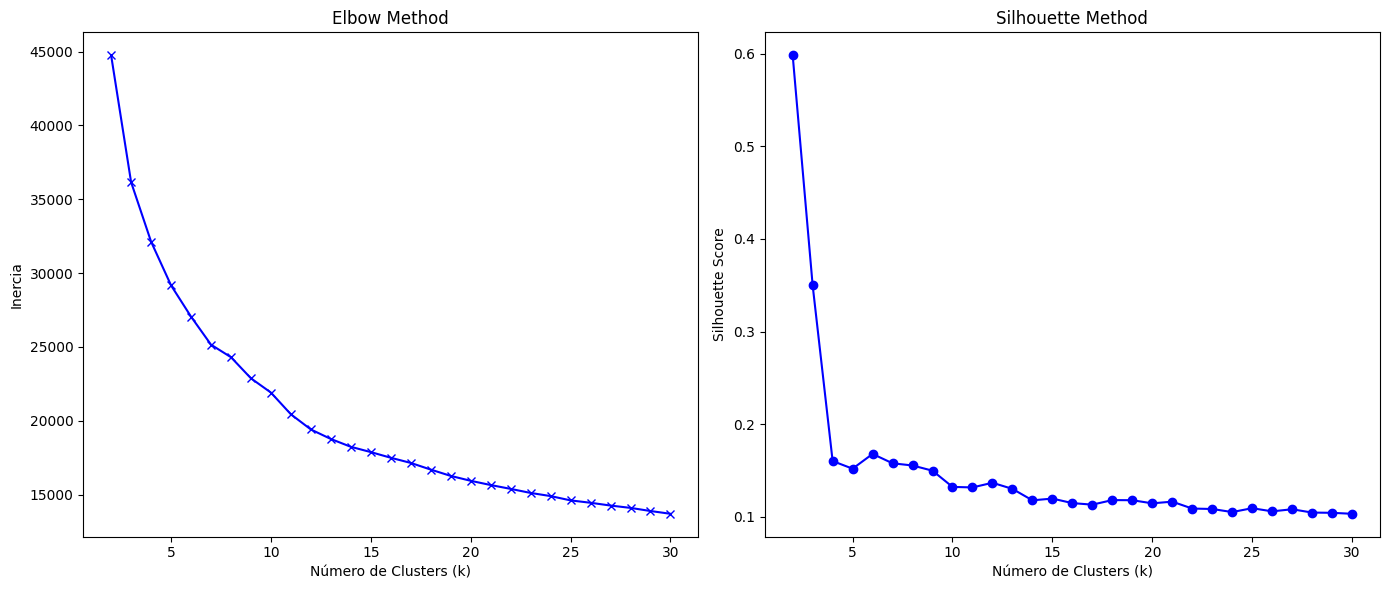

In [44]:
km_m.plot_elbow_silhouette(scaled_df, 30)

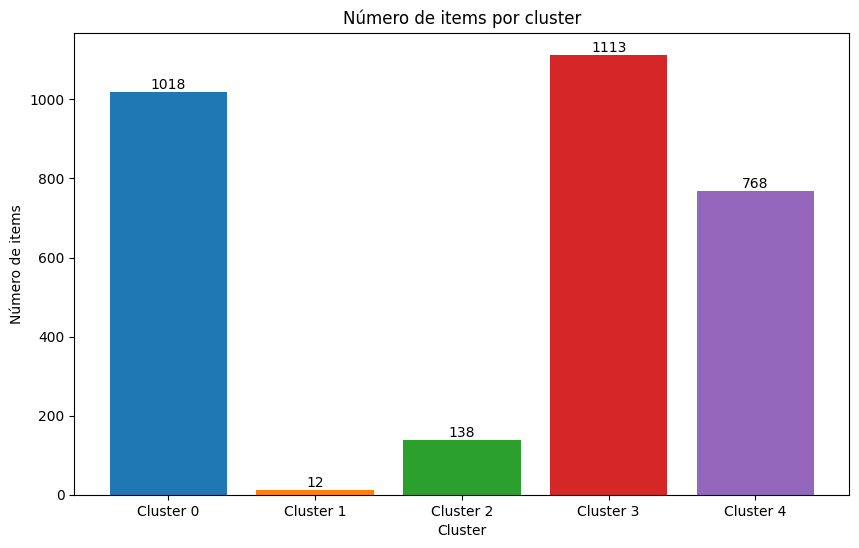

MEAN(sales.event_Easter)  MEAN(sales.event_NewYear)  \
item                                                                    
ACCESORIES_1_001                  0.003976                   0.002783   
ACCESORIES_1_002                  0.002286                   0.002286   
ACCESORIES_1_003                  0.005952                   0.006803   
ACCESORIES_1_004                  0.003625                   0.004198   
ACCESORIES_1_005                  0.002854                   0.003373   

                  MEAN(sales.event_None)  MEAN(sales.event_Ramadan starts)  \
item                                                                         
ACCESORIES_1_001                0.984891                          0.002386   
ACCESORIES_1_002                0.988000                          0.003429   
ACCESORIES_1_003                0.977041                          0.005102   
ACCESORIES_1_004                0.984163                          0.002480   
ACCESORIES_1_005                0.984172                          0.003373   

                  MEAN(sales.event_SuperBowl)  MEAN(sales.event_Thanksgiving)  \
item                                                                            
ACCESORIES_1_001                     0.003976                        0.001988   
ACCESORIES_1_002                     0.001714                        0.002286   
ACCESORIES_1_003                     0.003401                        0.001701   
ACCESORIES_1_004                     0.003434                        0.002099   
ACCESORIES_1_005                     0.003892                        0.002335   

                  MEAN(sales.raw_earn)  MEAN(sales.units)  \
item                                                        
ACCESORIES_1_001             15.315095           1.393241   
ACCESORIES_1_002              6.694430           1.268571   
ACCESORIES_1_003              4.806321           1.220238   
ACCESORIES_1_004             21.065210           3.413471   
ACCESORIES_1_005              6.509380           1.704463   

                  SUM(sales.event_Easter)  SUM(sales.event_NewYear)  \
item                                                                  
ACCESORIES_1_001                     10.0                       7.0   
ACCESORIES_1_002                      4.0                       4.0   
ACCESORIES_1_003                      7.0                       8.0   
ACCESORIES_1_004                     19.0                      22.0   
ACCESORIES_1_005                     11.0                      13.0   

                  SUM(sales.event_None)  SUM(sales.event_Ramadan starts)  \
item                                                                       
ACCESORIES_1_001                 2477.0                              6.0   
ACCESORIES_1_002                 1729.0                              6.0   
ACCESORIES_1_003                 1149.0                              6.0   
ACCESORIES_1_004                 5158.0                             13.0   
ACCESORIES_1_005                 3793.0                             13.0   

                  SUM(sales.event_SuperBowl)  SUM(sales.event_Thanksgiving)  \
item                                                                          
ACCESORIES_1_001                        10.0                            5.0   
ACCESORIES_1_002                         3.0                            4.0   
ACCESORIES_1_003                         4.0                            2.0   
ACCESORIES_1_004                        18.0                           11.0   
ACCESORIES_1_005                        15.0                            9.0   

                  SUM(sales.raw_earn)  Cluster  
item                                            
ACCESORIES_1_001           38517.4650        3  
ACCESORIES_1_002           11715.2518        0  
ACCESORIES_1_003            5652.2340        3  
ACCESORIES_1_004          110402.7680        4  
ACCESORIES_1_005           25087.1516        3

In [45]:
# Apreciamos varias opciones de 3 a 5
optimal_k = 5

kmeans_model, feature_matrix_with_clusters = km_m.apply_kmeans_and_plot(optimal_k, scaled_df, feature_matrix_renamed)

feature_matrix_with_clusters.head(5)

## Analisis

PCAs

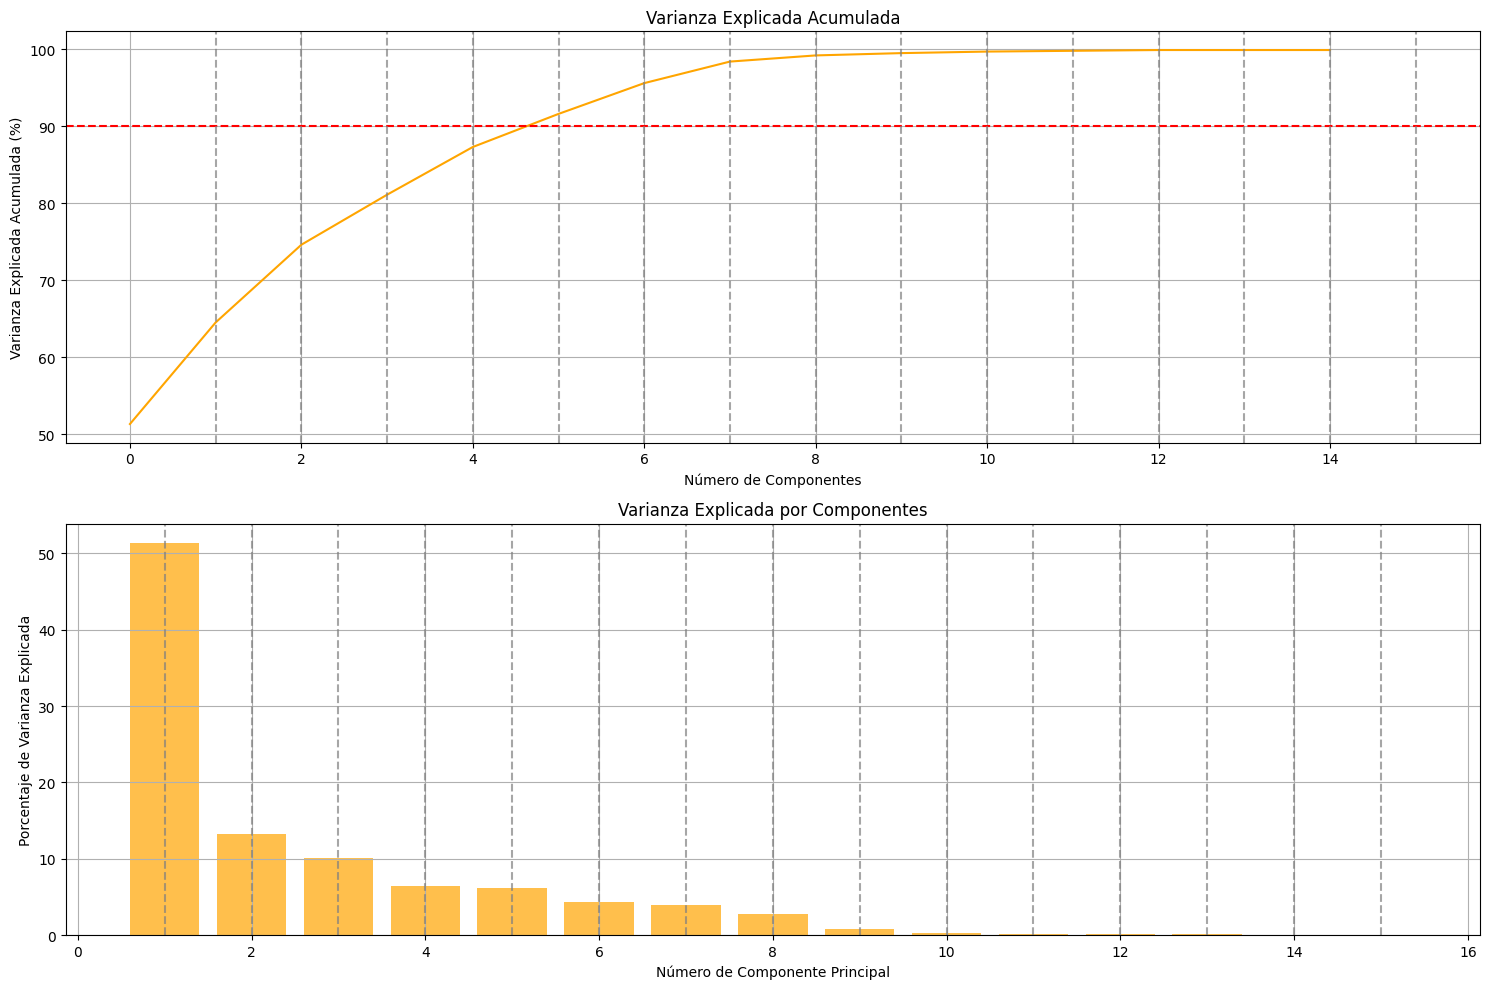

Varianza explicada por cada componente (%): [51.3 13.2 10.1  6.5  6.2  4.3  4.   2.8  0.8  0.3  0.2  0.1  0.1  0.
  0. ]


Componente 1  Componente 2  Componente 3  Componente 4  Componente 5  \
0          51.3          64.5          74.6          81.1          87.3   

   Componente 6  Componente 7  Componente 8  Componente 9  Componente 10  \
0          91.6          95.6          98.4          99.2           99.5   

   Componente 11  Componente 12  Componente 13  Componente 14  Componente 15  
0           99.7           99.8           99.9           99.9           99.9

In [46]:
variance_ratio = km_m.view_pca_variance(scaled_df)

acc_var = km_m.calculate_accumulated_variance(variance_ratio)

display(acc_var)

Importancia caracteristicas

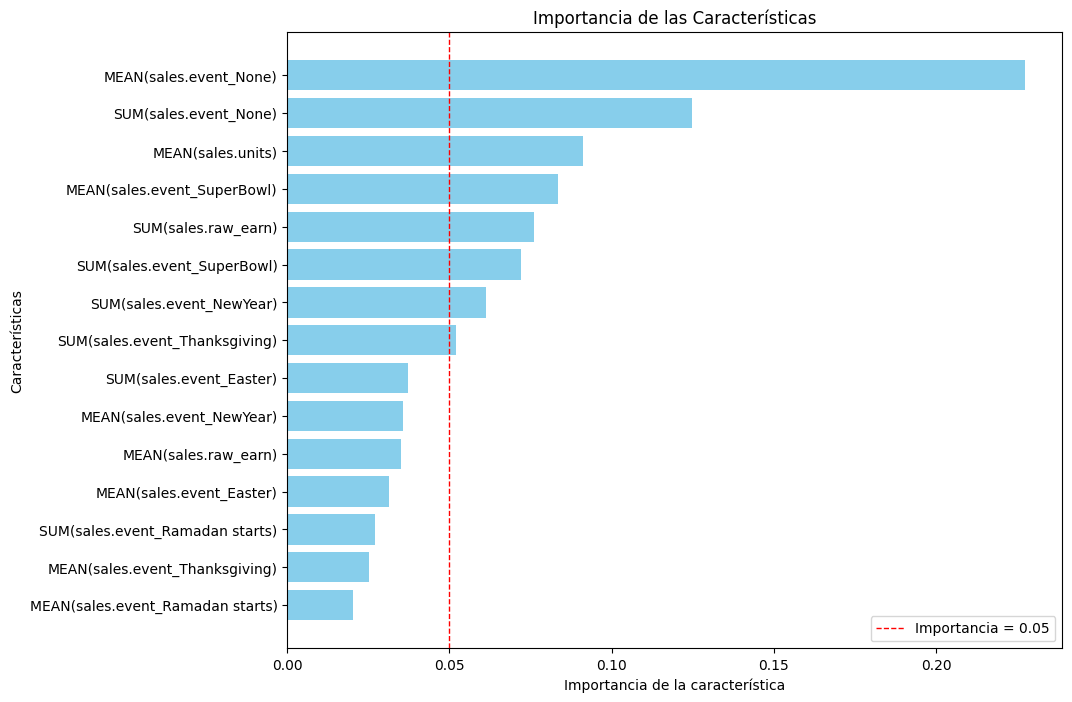

In [47]:
# Preprocesamos datos
cluster_col='Cluster'
cols_to_scale = feature_matrix_with_clusters.columns.tolist()
df_clusters = feature_matrix_with_clusters[[cluster_col]].copy().reset_index(drop=True)
cols_to_scale.remove(cluster_col) # Columna Objetivo

# Combinar los DataFrames basándose en la columna 'Index'
preprocessed_df = pd.concat([scaled_df, df_clusters], axis=1)

clusters = kmeans_model.labels_

IMPORTANCE_THRES=0.05
importance_df = km_m.get_feature_importances(preprocessed_df, clusters, imp_threshold=IMPORTANCE_THRES)

# Seleccionamos solo las caracteristicas que tienen importancia por encima o igual del umbral
selected_features = importance_df[importance_df['Importance'] >= IMPORTANCE_THRES]

# Creamos una lista con las features más importantes usando la columna feature de importance_df
most_important_features = selected_features['Feature'].tolist()

# display(importance_df.head(10))

## Dim Redux

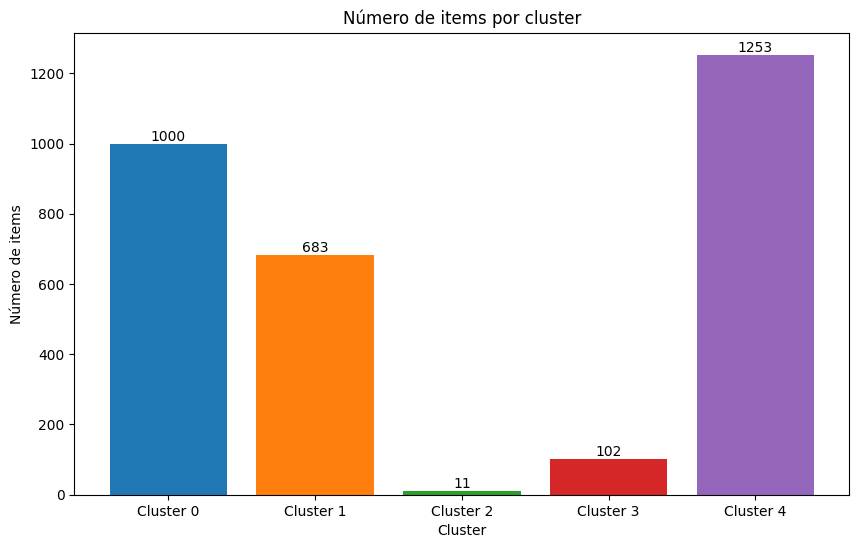

In [48]:
# Ejecutar PCA y clustering
n_components = 6 # Segun visto en varianza acumulada -> casi 90%

# Obtenemos scaled df con componentes y clusters
df_with_pca, loadings_df = km_m.pca_and_cluster(scaled_df, n_clusters=optimal_k, n_components=n_components)

# # Mostrar el DataFrame con PCA y clustering
# display(df_with_pca.head(5))

# Graficar la cantidad de items por cluster
show_clusters = km_m.plot_cluster_sizes(df_with_pca)

## Descripcion de los clusters

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

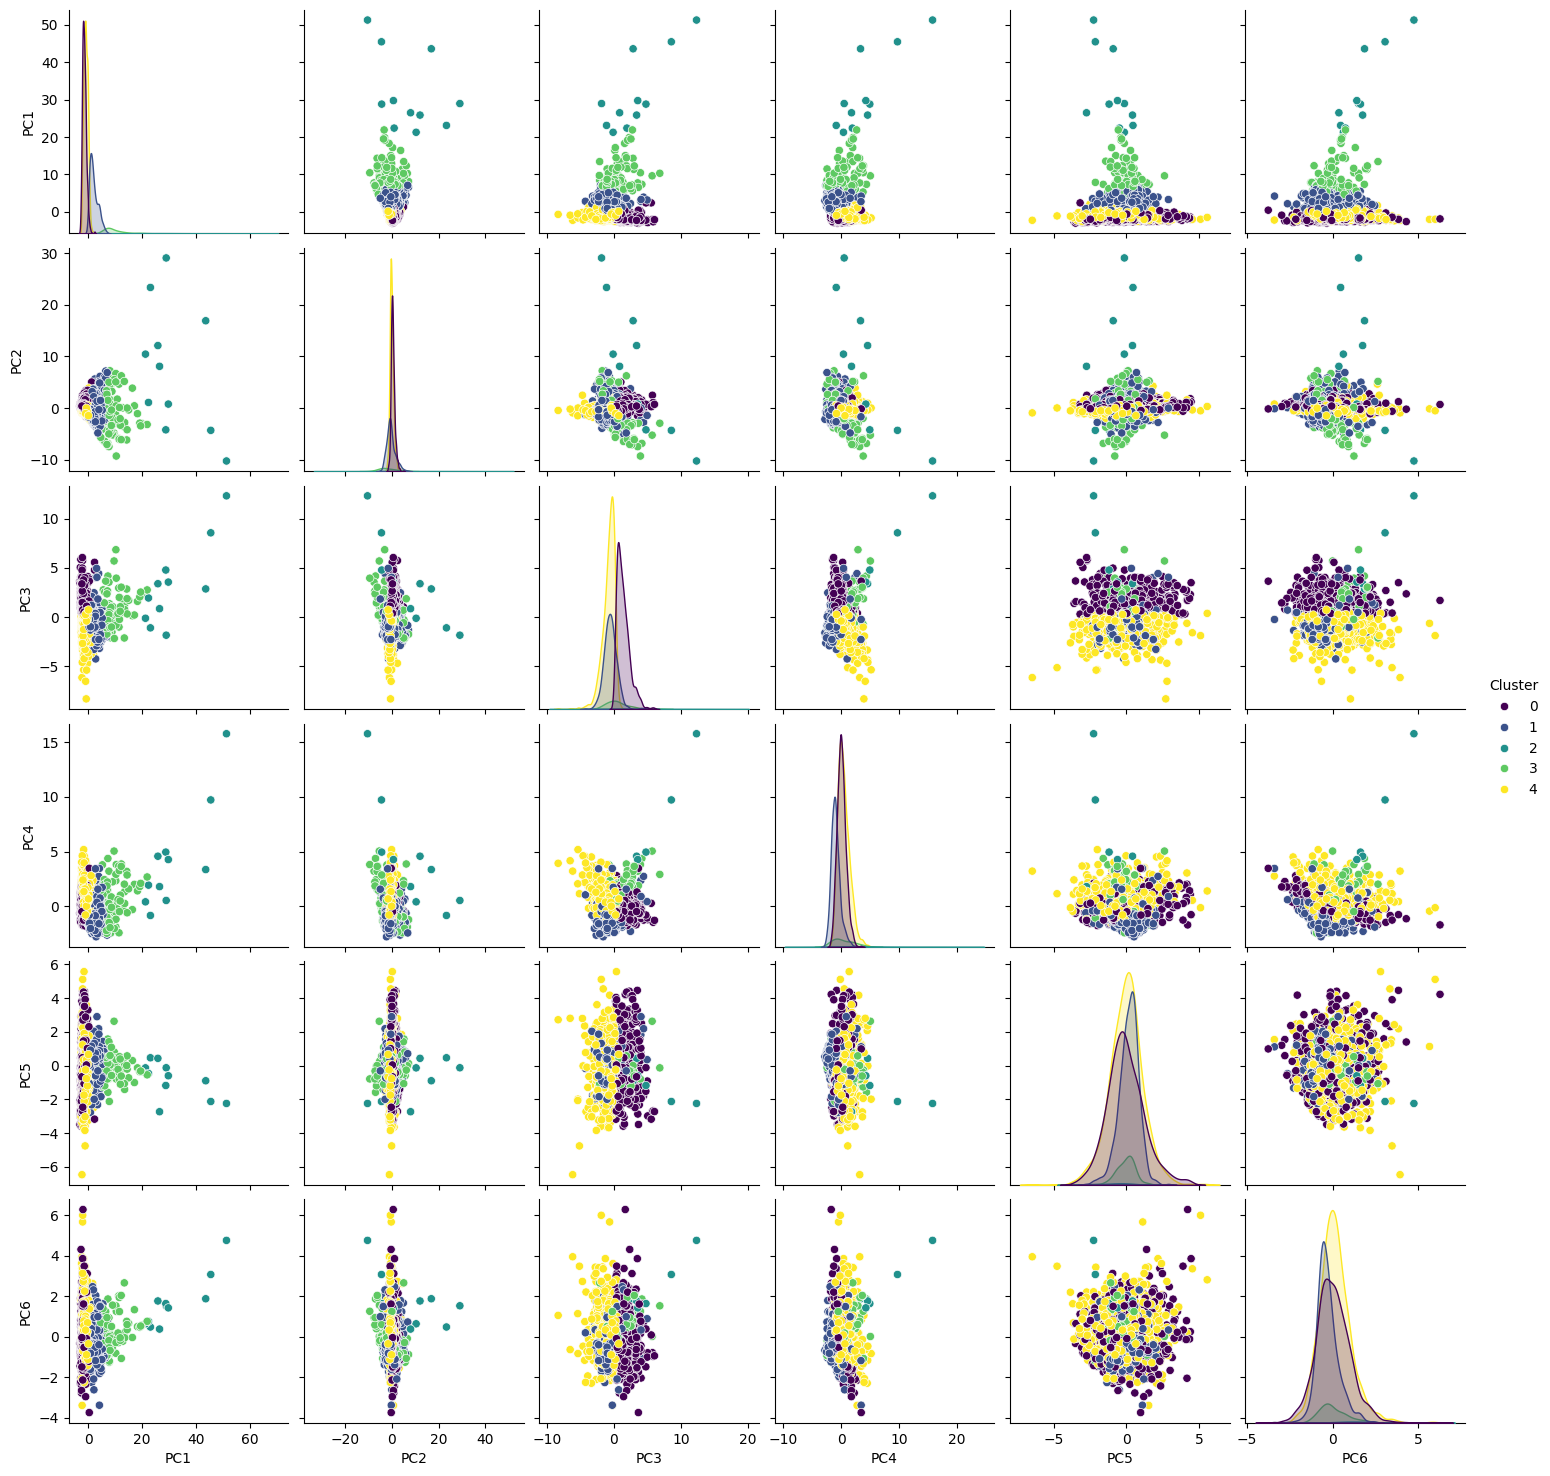

In [49]:
# Visualizacion clusters
cols = n_components + 1 # -> Seleccionamos solo las columnas de PC y Cluster
df_pairplot = df_with_pca.iloc[:, -(cols):]

# display(df_pairplot.head())

df_pairplot['Cluster'] = df_with_pca['Cluster']
sns.pairplot(df_pairplot[0:], hue='Cluster', palette='viridis')

**Analisis**  
  
Estos no estan tan claros. Parece haber bastantes solapamientos.

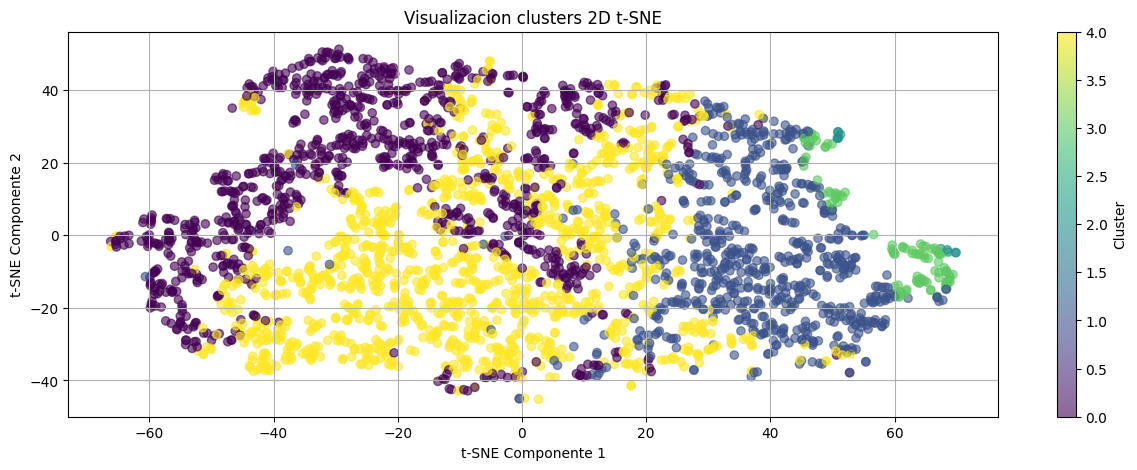

In [50]:
# T SNE visualizacion de clusters
km_m.tsne_visualization(df_pairplot, n_components=2, perplexity=30)

**Analisis**  
  
Aparecen bastantes solapamientos. Habría que probar con otro optimal_k (3 quizás)

Mostrar Descripcions

In [ ]:
# Seleccionamos las features según la lista most_important_features obtenida con random forest
importance_df_filt = importance_df[importance_df['Feature'].isin(most_important_features)]

# Crear y mostrar descripciones de los clusters
description_df = km_m.create_cluster_descriptions(df_with_pca, importance_df_filt)
print('###########################################################')
print('Descripcion de los clusters')
print('###########################################################')
# Ordenamos columnas de description_df usando sort
description_df = description_df[sorted(description_df.columns)]
display(description_df)

Asignacion clusters a items

In [ ]:
# Añadimos clusters a df_items
df_items = df_items.reset_index(drop=True) # Recuperamos indices originales

df_items_with_clusters = df_items.merge(df_with_pca[['Cluster']], left_index=True, right_index=True)

df_items_with_clusters.head()

In [ ]:
# Crear dataframe con las descripciones de los clusters
# Daily sales
cluster_summary = {

}

cluster_summary_df = pd.DataFrame.from_dict(cluster_summary, orient='index')

# Asumiendo que tienes un dataframe `items_df` que tiene una columna 'cluster' con los números de cluster
# Realiza un merge con el resumen de clusters para añadir los nombres y descripciones al dataframe original
items_with_cluster_info = df_items_with_clusters.merge(cluster_summary_df, left_on='Cluster', right_index=True, how='left')

items_with_cluster_info = items_with_cluster_info.rename(columns={'Cluster':'cluster'})

# Resultado: `items_with_cluster_info` tendrá las columnas adicionales 'cluster_name' y 'description'
display(items_with_cluster_info.head())

Plot clusters con descripcion

In [ ]:
km_m.plot_clusters_with_name(items_with_cluster_info)

## Guardamos CSV

In [ ]:
# Guardamos df como csv
from google.colab import files

file_name = 'items_clusters_events_influence_sales.csv'

# # Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
# items_with_cluster_info.to_csv(file_name, index=False)

# # Descargar el archivo CSV
# files.download(file_name)

___
___